In [1]:
import sys
sys.path.append('..')
sys.path.append('../../src/')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from os import path
from glob import glob

import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, GlobalAvgPool2D
from keras.layers import Dense, Dropout, Concatenate
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence

from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from utils import load, plot
from local_config import FOLDER_IMAGES, FOLDER_MODELS
from global_config import RANDOM_SEED, IMAGE_SIZE
from custom_metrics import precision, recall, f1, specificity 
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import equal_error_rate as eer

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
FILE_BASE_MODEL = '../../models/siamese_networks/autoencoder_2020_06_02-22_00_23.h5'

VALID_SIZE = 0.2
BATCH_SIZE = 32
ALPHA = 100
EPOCHS = 100
MLFLOW_EXPERIMENT_NAME = 'Siamese Networks'

print(FILE_BASE_MODEL)
print(FOLDER_IMAGES)
print(FOLDER_MODELS)

../../models/siamese_networks/autoencoder_2020_06_02-22_00_23.h5
../../data/siamese_networks
../../models/siamese_networks


In [3]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)    

In [4]:
def load_pos_and_neg_images(req_name):
    pos_files = glob(f"{FOLDER_IMAGES}/{req_name}/positives/*")
    neg_files = glob(f"{FOLDER_IMAGES}/{req_name}/negatives/*")
    
    x_pos = load.images_from_list_files(pos_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    x_neg = load.images_from_list_files(neg_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    
    x_pos_train, x_pos_valid = train_test_split(x_pos, test_size=VALID_SIZE, random_state=RANDOM_SEED)
    x_neg_train, x_neg_valid = train_test_split(x_neg, test_size=VALID_SIZE, random_state=RANDOM_SEED)
    
    return x_pos_train, x_pos_valid, x_neg_train, x_neg_valid


def setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid):
    x_train = np.concatenate((x_pos_train, x_neg_train), axis=0)
    y_train = np.array([1]*x_pos_train.shape[0] + [0]*x_neg_train.shape[0])
    
    x_valid = np.concatenate((x_pos_valid, x_neg_valid), axis=0)
    y_valid = np.array([1]*x_pos_valid.shape[0] + [0]*x_neg_valid.shape[0])
    
    return x_train, y_train, x_valid, y_valid

In [5]:
def print_metrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))
    print()

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Triplet Generator 

In [6]:
class RandomTripletGenerator(Sequence):
    """Generate Random Triplets (A, P, N) for Siamese Networks on the fly"""

    def __init__(self, pos_images, neg_images, emb_dim, batch_size=1, datagen=ImageDataGenerator(), random_seed=None):
        self.pos_images = pos_images
        self.neg_images = neg_images
        self.emb_dim = emb_dim
        self.batch_size = min(pos_images.shape[0], neg_images.shape[0], batch_size)
        self.datagen = datagen
        np.random.seed(random_seed)
        
    def __len__(self):
        n_pos = self.pos_images.shape[0]
        n_neg = self.neg_images.shape[0]
        return min(n_pos, n_neg) // self.batch_size
        
    def __getitem__(self, idx):
        anc_batch = self.datagen.flow(self.neg_images, batch_size=self.batch_size).next()
        pos_batch = self.datagen.flow(self.pos_images, batch_size=self.batch_size).next()
        neg_batch = self.datagen.flow(self.neg_images, batch_size=self.batch_size).next()
        
        x = [anc_batch, neg_batch, pos_batch]
        y = np.zeros(shape=(self.batch_size, 3 * self.emb_dim))
        return x, y


class DeterministicTripletGenerator(Sequence):
    def __init__(self, triplet_gen, steps_per_epoch):
        self.steps_per_epoch = steps_per_epoch
        self.anc_gen = []
        self.pos_gen = []
        self.neg_gen = []
        self.y_gen = []
        
        for i in range(steps_per_epoch):
            (anc, neg, pos), y = triplet_gen.__getitem__(None)
            self.anc_gen.append(anc)
            self.neg_gen.append(neg)
            self.pos_gen.append(pos)
            self.y_gen.append(y)
            
    def __len__(self):
        return self.steps_per_epoch
        
    def __getitem__(self, idx):
        anc_batch = self.anc_gen[idx]
        neg_batch = self.neg_gen[idx]
        pos_batch = self.pos_gen[idx]
        y_batch = self.y_gen[idx]
        
        return [anc_batch, neg_batch, pos_batch], y_batch

# Classification Generator 

In [7]:
class RandomBalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen=ImageDataGenerator(), batch_size=1):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        self._shape = x.shape   
        
        self.datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(
            x.reshape(x.shape[0], -1), 
            y, 
            sampler=RandomOverSampler(), 
            batch_size=self.batch_size, 
            keep_sparse=True
        )
        
    def __len__(self):
        return self.steps_per_epoch   
    
    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()


class DeterministicBalancedGenerator(Sequence):
    def __init__(self, balanced_gen):
        self.x_gen = []
        self.y_gen = []
        self.steps_per_epoch = balanced_gen.steps_per_epoch
        
        for i in range(balanced_gen.steps_per_epoch):
            x, y = balanced_gen.__getitem__(None)
            self.x_gen.append(x)
            self.y_gen.append(y)
        
    def __len__(self):
        return self.steps_per_epoch
        
    def __getitem__(self, idx):
        return self.x_gen[idx], self.y_gen[idx]

# Triplet Loss 

In [8]:
def triplet_loss(alpha=0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
        anc -- the encodings for the anchor data
        pos -- the encodings for the positive data
        neg -- the encodings for the negative data
    Returns:
    loss -- real number, value of the loss
    """
    def loss_func(y_true, y_pred):
        total_length = y_pred.shape.as_list()[-1]

        anc = y_pred[:, 0:int(total_length * 1/3)]
        pos = y_pred[:, int(total_length * 1/3):int(total_length * 2/3)]
        neg = y_pred[:, int(total_length * 2/3):int(total_length * 3/3)]
        
        pos_dist = K.sum(K.square(anc - pos), axis=1)
        neg_dist = K.sum(K.square(anc - neg), axis=1)

        loss = K.maximum(pos_dist - neg_dist + alpha, 0.0)
        return loss
 
    return loss_func

# Training Functions 

In [9]:
def load_encoder(file_encoder):
    autoencoder = load_model(file_encoder)
    encoder_output = autoencoder.get_layer(name='encoded').output
    encoder = Model(inputs=autoencoder.inputs, outputs=encoder_output)
    return encoder


def build_shared_model(base_model, name):
    set_random_seeds()
    
    req_emb = GlobalAvgPool2D()(base_model.output)
    req_emb = Dropout(rate=0.5)(req_emb)
    req_emb = Dense(units=128, activation='relu', name=f'{name}_embeddings_1')(req_emb)
    req_emb = Dropout(rate=0.5)(req_emb)
    req_emb = Dense(units=128, activation='tanh', name=f'{name}_embeddings')(req_emb)
    req_model = Model(inputs=base_model.inputs, outputs=req_emb)

    for layer in req_model.layers:
        layer.trainable = (name in layer.name)
    return req_model


def build_siamese_model(base_model):
    set_random_seeds()

    input_anc = Input(shape=(*IMAGE_SIZE, 3))
    input_pos = Input(shape=(*IMAGE_SIZE, 3))
    input_neg = Input(shape=(*IMAGE_SIZE, 3))

    output_anc = base_model(input_anc)
    output_pos = base_model(input_pos)
    output_neg = base_model(input_neg)

    inputs = [input_anc, input_pos, input_neg]
    outputs = Concatenate(axis=-1)([output_anc, output_pos, output_neg])

    triplet_model = Model(inputs, outputs)
    triplet_model.compile(optimizer='adam', loss=triplet_loss(ALPHA))
    return triplet_model


def build_classification_model(base_model, name):
    set_random_seeds()
    
    output_name = f'{name}_embeddings'
    outputs = base_model.get_layer(output_name).output
    outputs = Dropout(rate=0.5)(outputs)
    outputs = Dense(units=128, activation='relu', name=f'{name}_dense')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = name.endswith(layer.name)
        
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc, eer]
    )
    
    return model

In [10]:
def train_siamese_model(model, train_gen, valid_gen):
    list_callbacks = [
        EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True),
    ]
    
    hist = model.fit_generator(
        train_gen, 
        steps_per_epoch=100,
        epochs=EPOCHS,
        validation_data=valid_gen,
        validation_steps=valid_gen.steps_per_epoch,
        callbacks=list_callbacks
    )
    
    plot.keras_hist(hist.history)


def train_classification_model(model, train_gen, valid_gen, name):
    FILE_MODEL = FOLDER_MODELS + '/' + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=50, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("alpha", ALPHA)
    mlflow.log_param("valid_size", VALID_SIZE)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("file_model", FILE_MODEL)
    mlflow.set_tag("requirement", name)
    mlflow.keras.autolog()

    hist = model.fit_generator(
        train_gen, 
        steps_per_epoch=train_gen.steps_per_epoch,
        epochs=EPOCHS,
        validation_data=valid_gen,
        validation_steps=valid_gen.steps_per_epoch,
        callbacks=list_callbacks
    )
    
    plot.keras_hist(hist.history)
    mlflow.end_run()
    
    return FILE_MODEL

In [11]:
def run_siamese_training(file_encoder, train_data, valid_data, train_gen, valid_gen, name):
    model_encoder = load_encoder(file_encoder)
    model_shared = build_shared_model(model_encoder, name)
    model_siamese = build_siamese_model(model_shared)
    
    emb_dim = model_siamese.output_shape[-1] // 3
    
    x_pos_train, x_neg_train = train_data
    x_pos_valid, x_neg_valid = valid_data
    seed_triplet = RandomTripletGenerator(x_pos_valid, x_neg_valid, emb_dim, BATCH_SIZE, valid_gen, RANDOM_SEED)
    train_gen_triplet = RandomTripletGenerator(x_pos_train, x_neg_train, emb_dim, BATCH_SIZE, train_gen)
    valid_gen_triplet = DeterministicTripletGenerator(seed_triplet, steps_per_epoch=100)
    
    train_siamese_model(model_siamese, train_gen_triplet, valid_gen_triplet)

    return model_shared


def run_classification_training(model_shared, train_data, valid_data, train_gen, valid_gen, name):
    x_train, y_train = train_data
    x_valid, y_valid = valid_data
    
    valid_bal = RandomBalancedDataGenerator(x_valid, y_valid, valid_gen, BATCH_SIZE)
    train_gen_bal = RandomBalancedDataGenerator(x_train, y_train, train_gen, BATCH_SIZE)
    valid_gen_bal = DeterministicBalancedGenerator(valid_bal)
    
    model_classification = build_classification_model(model_shared, name)
    file_model = train_classification_model(model_classification, train_gen_bal, valid_gen_bal, name)

    x_gen = valid_gen.flow(x_valid, batch_size=len(y_valid), shuffle=False).next()
    y_pred = model_classification.predict(x_gen).flatten()
    y_pred = np.where(y_pred > 0.5, 1, 0)
    print_metrics(y_valid, y_pred)
    
    return file_model

# Requirements Training 

In [12]:
list_model_files = []

#### 2. Blurred

71 of 71
48 of 48
(94, 160, 160, 3) float32
(94,) int32
(25, 160, 160, 3) float32
(25,) int32
Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 50s 499ms/step - loss: 100.3789 - val_loss: 96.6768
Epoch 2/100
100/100 [==============================] - 47s 465ms/step - loss: 99.0536 - val_loss: 86.0249
Epoch 3/100
100/100 [==============================] - 45s 448ms/step - loss: 95.7554 - val_loss: 66.0355
Epoch 4/100
100/100 [==============================] - 51s 506ms/step - loss: 94.1453 - val_loss: 69.1126
Epoch 5/100
100/100 [==============================] - 45s 454ms/step - loss: 93.9562 - val_loss: 71.6083
Epoch 6/100
100/100 [==============================] - 45s 454ms/step - loss: 92.5745 - val_loss: 71.8779
Epoch 7/100
100/100 [==============================] - 45s 452ms/step - loss: 88.2418 - val_loss: 69.1949
Epoch 8/100
100/100 [==============================] - 45s 448ms/step - loss: 85.0813 - val_loss: 63.0899
Epoch 9/100
100/100 [==============================] - 45s 446ms/step - loss: 82.8627 - val_loss: 73.51

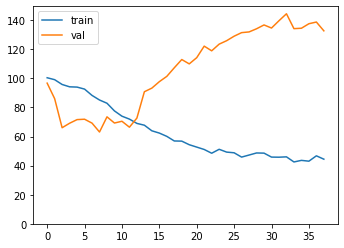

In [13]:
REQ_NAME = 'blurred'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    width_shift_range=0.3, 
    height_shift_range=0.3, 
    brightness_range=(0.7, 1.3),
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 1s 455ms/step - loss: 0.7649 - accuracy: 0.4896 - precision: 0.4833 - recall: 0.5556 - f1: 0.5169 - specificity: 0.3905 - negative_predictive_value: 0.4571 - matthews_correlation_coefficient: -0.0568 - equal_error_rate: 0.5210 - val_loss: 0.6371 - val_accuracy: 0.6800 - val_precision: 0.8750 - val_recall: 0.5000 - val_f1: 0.6364 - val_specificity: 0.9091 - val_negative_predictive_value: 0.5882 - val_matthews_correlation_coefficient: 0.4353 - val_equal_error_rate: 0.2695

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.43532, saving model to ../../models/siamese_networks/blurred_2020_06_13-00_54_46.h5
Epoch 2/100
3/3 [==============================] - 1s 217ms/step - loss: 0.7710 - accuracy: 0.5375 - precision: 0.5614 - recall: 0.5556 - f1: 0.5578 - specificity: 0.5000 - negative_predictive_value: 0.4968 - matthews_correlation_coefficient: 0.0569 - equal_error_rate: 0.5089 - val_loss: 0.6405 - val_accuracy: 0.6

3/3 [==============================] - 0s 144ms/step - loss: 0.7500 - accuracy: 0.5500 - precision: 0.6195 - recall: 0.5324 - f1: 0.5468 - specificity: 0.6429 - negative_predictive_value: 0.5783 - matthews_correlation_coefficient: 0.1861 - equal_error_rate: 0.4051 - val_loss: 0.6699 - val_accuracy: 0.6000 - val_precision: 0.8333 - val_recall: 0.3571 - val_f1: 0.5000 - val_specificity: 0.9091 - val_negative_predictive_value: 0.5263 - val_matthews_correlation_coefficient: 0.3094 - val_equal_error_rate: 0.3052

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.43532
Epoch 15/100
3/3 [==============================] - 0s 148ms/step - loss: 0.8068 - accuracy: 0.4625 - precision: 0.4317 - recall: 0.4213 - f1: 0.4229 - specificity: 0.4929 - negative_predictive_value: 0.4815 - matthews_correlation_coefficient: -0.0863 - equal_error_rate: 0.5429 - val_loss: 0.6708 - val_accuracy: 0.6000 - val_precision: 0.8333 - val_recall: 0.3571 - val_f1: 0.5000 - val_specificity: 0.909


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.43532
Epoch 28/100
3/3 [==============================] - 0s 156ms/step - loss: 0.7309 - accuracy: 0.5500 - precision: 0.5458 - recall: 0.5324 - f1: 0.5185 - specificity: 0.5702 - negative_predictive_value: 0.5625 - matthews_correlation_coefficient: 0.1053 - equal_error_rate: 0.4691 - val_loss: 0.6730 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.4286 - val_f1: 0.5455 - val_specificity: 0.8182 - val_negative_predictive_value: 0.5294 - val_matthews_correlation_coefficient: 0.2626 - val_equal_error_rate: 0.4773

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.43532
Epoch 29/100
3/3 [==============================] - 0s 166ms/step - loss: 0.7495 - accuracy: 0.4896 - precision: 0.4753 - recall: 0.4444 - f1: 0.4545 - specificity: 0.5024 - negative_predictive_value: 0.4679 - matthews_correlation_coefficient: -0.0549 - equal_error_rate: 0.5102 - val_loss: 0.6731 - val_accuracy: 

3/3 [==============================] - 0s 166ms/step - loss: 0.7102 - accuracy: 0.5833 - precision: 0.5787 - recall: 0.6019 - f1: 0.5861 - specificity: 0.5643 - negative_predictive_value: 0.5833 - matthews_correlation_coefficient: 0.1641 - equal_error_rate: 0.4374 - val_loss: 0.6904 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.4286 - val_f1: 0.5455 - val_specificity: 0.8182 - val_negative_predictive_value: 0.5294 - val_matthews_correlation_coefficient: 0.2626 - val_equal_error_rate: 0.4773

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.43532
Epoch 42/100
3/3 [==============================] - 0s 149ms/step - loss: 0.7117 - accuracy: 0.6250 - precision: 0.6801 - recall: 0.5787 - f1: 0.6228 - specificity: 0.6845 - negative_predictive_value: 0.5819 - matthews_correlation_coefficient: 0.2626 - equal_error_rate: 0.3528 - val_loss: 0.6931 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.4286 - val_f1: 0.5455 - val_specificity: 0.8182

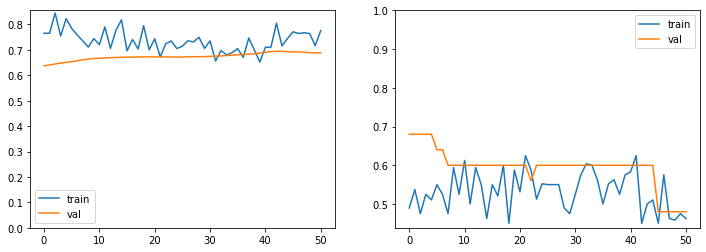

In [14]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 3. Looking Away

146 of 146
159 of 159
(243, 160, 160, 3) float32
(243,) int32
(62, 160, 160, 3) float32
(62,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 56s 563ms/step - loss: 100.1689 - val_loss: 99.7479
Epoch 2/100
100/100 [==============================] - 55s 547ms/step - loss: 100.1387 - val_loss: 98.7765
Epoch 3/100
100/100 [==============================] - 55s 550ms/step - loss: 99.6381 - val_loss: 98.0725
Epoch 4/100
100/100 [==============================] - 54s 544ms/step - loss: 98.5982 - val_loss: 97.1384
Epoch 5/100
100/100 [==============================] - 55s 555ms/step - loss: 98.3923 - val_loss: 98.1770
Epoch 6/100
100/100 [==============================] - 55s 550ms/step - loss: 97.2219 - val_loss: 100.3761
Epoch 7/100
100/100 [==============================] - 54s 543ms/step - loss: 97.5867 - val_loss: 96.3358
Epoch 8/100
100/100 [==============================] - 55s 547ms/step - loss: 97.0332 - val_loss: 99.8775
Epoch 9/100
100/100 [==============================] - 55s 550ms/step - loss: 96.0809 - val_loss: 102.1378
Epoch 10/100
100/100 [====================

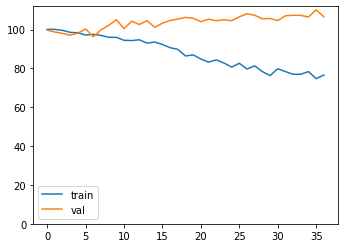

In [15]:
REQ_NAME = 'looking_away'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 2s 288ms/step - loss: 0.8127 - accuracy: 0.4732 - precision: 0.4638 - recall: 0.6988 - f1: 0.5555 - specificity: 0.2634 - negative_predictive_value: 0.4908 - matthews_correlation_coefficient: -0.0411 - equal_error_rate: 0.4698 - val_loss: 0.6912 - val_accuracy: 0.5312 - val_precision: 0.5179 - val_recall: 0.7745 - val_f1: 0.6190 - val_specificity: 0.2725 - val_negative_predictive_value: 0.5417 - val_matthews_correlation_coefficient: 0.0523 - val_equal_error_rate: 0.4686

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.05226, saving model to ../../models/siamese_networks/looking_away_2020_06_13-01_29_34.h5
Epoch 2/100
7/7 [==============================] - 1s 170ms/step - loss: 0.7617 - accuracy: 0.5000 - precision: 0.5054 - recall: 0.5983 - f1: 0.5445 - specificity: 0.3958 - negative_predictive_value: 0.4874 - matthews_correlation_coefficient: -0.0065 - equal_error_rate: 0.4950 - val_loss: 0.6833 - val_accurac

7/7 [==============================] - 1s 159ms/step - loss: 0.7625 - accuracy: 0.4550 - precision: 0.4667 - recall: 0.4744 - f1: 0.4681 - specificity: 0.4276 - negative_predictive_value: 0.4351 - matthews_correlation_coefficient: -0.0981 - equal_error_rate: 0.5481 - val_loss: 0.6675 - val_accuracy: 0.5000 - val_precision: 0.4880 - val_recall: 0.6451 - val_f1: 0.5514 - val_specificity: 0.3353 - val_negative_predictive_value: 0.5000 - val_matthews_correlation_coefficient: -0.0163 - val_equal_error_rate: 0.4373

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.05226
Epoch 15/100
7/7 [==============================] - 1s 159ms/step - loss: 0.7323 - accuracy: 0.5135 - precision: 0.5056 - recall: 0.4902 - f1: 0.4888 - specificity: 0.5465 - negative_predictive_value: 0.5301 - matthews_correlation_coefficient: 0.0362 - equal_error_rate: 0.4686 - val_loss: 0.6673 - val_accuracy: 0.5000 - val_precision: 0.4880 - val_recall: 0.6451 - val_f1: 0.5514 - val_specificity: 0.33


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.05226
Epoch 28/100
7/7 [==============================] - 1s 158ms/step - loss: 0.7263 - accuracy: 0.5180 - precision: 0.5326 - recall: 0.5024 - f1: 0.5077 - specificity: 0.5495 - negative_predictive_value: 0.5190 - matthews_correlation_coefficient: 0.0517 - equal_error_rate: 0.4946 - val_loss: 0.6652 - val_accuracy: 0.5156 - val_precision: 0.5026 - val_recall: 0.6451 - val_f1: 0.5589 - val_specificity: 0.3647 - val_negative_predictive_value: 0.5147 - val_matthews_correlation_coefficient: 0.0131 - val_equal_error_rate: 0.4373

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.05226
Epoch 29/100
7/7 [==============================] - 1s 164ms/step - loss: 0.7191 - accuracy: 0.5045 - precision: 0.5276 - recall: 0.4874 - f1: 0.4994 - specificity: 0.5334 - negative_predictive_value: 0.4931 - matthews_correlation_coefficient: 0.0208 - equal_error_rate: 0.4808 - val_loss: 0.6646 - val_accuracy: 0

7/7 [==============================] - 1s 166ms/step - loss: 0.7052 - accuracy: 0.5179 - precision: 0.4943 - recall: 0.5621 - f1: 0.5243 - specificity: 0.4741 - negative_predictive_value: 0.5427 - matthews_correlation_coefficient: 0.0366 - equal_error_rate: 0.5005 - val_loss: 0.6665 - val_accuracy: 0.5469 - val_precision: 0.5218 - val_recall: 0.6745 - val_f1: 0.5822 - val_specificity: 0.3980 - val_negative_predictive_value: 0.5980 - val_matthews_correlation_coefficient: 0.0933 - val_equal_error_rate: 0.4373

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.09330
Epoch 42/100
7/7 [==============================] - 1s 164ms/step - loss: 0.7168 - accuracy: 0.4775 - precision: 0.5078 - recall: 0.4607 - f1: 0.4619 - specificity: 0.5367 - negative_predictive_value: 0.4848 - matthews_correlation_coefficient: -0.0050 - equal_error_rate: 0.4854 - val_loss: 0.6664 - val_accuracy: 0.5625 - val_precision: 0.5385 - val_recall: 0.6745 - val_f1: 0.5902 - val_specificity: 0.427

7/7 [==============================] - 1s 168ms/step - loss: 0.7216 - accuracy: 0.4459 - precision: 0.4397 - recall: 0.4242 - f1: 0.4246 - specificity: 0.4640 - negative_predictive_value: 0.4360 - matthews_correlation_coefficient: -0.1178 - equal_error_rate: 0.5131 - val_loss: 0.6712 - val_accuracy: 0.5625 - val_precision: 0.5417 - val_recall: 0.6451 - val_f1: 0.5828 - val_specificity: 0.4608 - val_negative_predictive_value: 0.5903 - val_matthews_correlation_coefficient: 0.1180 - val_equal_error_rate: 0.4539

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.12288
Epoch 55/100
7/7 [==============================] - 1s 175ms/step - loss: 0.6935 - accuracy: 0.5225 - precision: 0.5162 - recall: 0.5561 - f1: 0.5264 - specificity: 0.5004 - negative_predictive_value: 0.5398 - matthews_correlation_coefficient: 0.0562 - equal_error_rate: 0.4724 - val_loss: 0.6709 - val_accuracy: 0.5625 - val_precision: 0.5417 - val_recall: 0.6451 - val_f1: 0.5828 - val_specificity: 0.460

7/7 [==============================] - 1s 162ms/step - loss: 0.7112 - accuracy: 0.4955 - precision: 0.5067 - recall: 0.5402 - f1: 0.5117 - specificity: 0.4760 - negative_predictive_value: 0.5055 - matthews_correlation_coefficient: 0.0142 - equal_error_rate: 0.4990 - val_loss: 0.6742 - val_accuracy: 0.5938 - val_precision: 0.5736 - val_recall: 0.6451 - val_f1: 0.6000 - val_specificity: 0.5235 - val_negative_predictive_value: 0.6228 - val_matthews_correlation_coefficient: 0.1818 - val_equal_error_rate: 0.4225

Epoch 00067: val_matthews_correlation_coefficient improved from 0.14816 to 0.18182, saving model to ../../models/siamese_networks/looking_away_2020_06_13-01_29_34.h5
Epoch 68/100
7/7 [==============================] - 1s 167ms/step - loss: 0.7069 - accuracy: 0.5135 - precision: 0.5222 - recall: 0.4944 - f1: 0.5018 - specificity: 0.5368 - negative_predictive_value: 0.5107 - matthews_correlation_coefficient: 0.0321 - equal_error_rate: 0.4770 - val_loss: 0.6740 - val_accuracy: 0.5938 

7/7 [==============================] - 1s 157ms/step - loss: 0.7180 - accuracy: 0.5000 - precision: 0.5052 - recall: 0.5209 - f1: 0.5081 - specificity: 0.4700 - negative_predictive_value: 0.4820 - matthews_correlation_coefficient: -0.0110 - equal_error_rate: 0.5025 - val_loss: 0.6733 - val_accuracy: 0.6250 - val_precision: 0.6026 - val_recall: 0.6451 - val_f1: 0.6184 - val_specificity: 0.5902 - val_negative_predictive_value: 0.6531 - val_matthews_correlation_coefficient: 0.2452 - val_equal_error_rate: 0.3765

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.25343
Epoch 81/100
7/7 [==============================] - 1s 172ms/step - loss: 0.7072 - accuracy: 0.4821 - precision: 0.4577 - recall: 0.4928 - f1: 0.4721 - specificity: 0.4712 - negative_predictive_value: 0.5063 - matthews_correlation_coefficient: -0.0360 - equal_error_rate: 0.5579 - val_loss: 0.6738 - val_accuracy: 0.6094 - val_precision: 0.5942 - val_recall: 0.6157 - val_f1: 0.6014 - val_specificity: 0.59

7/7 [==============================] - 1s 165ms/step - loss: 0.6898 - accuracy: 0.5946 - precision: 0.6194 - recall: 0.5653 - f1: 0.5860 - specificity: 0.6339 - negative_predictive_value: 0.5771 - matthews_correlation_coefficient: 0.1978 - equal_error_rate: 0.4218 - val_loss: 0.6748 - val_accuracy: 0.6094 - val_precision: 0.5762 - val_recall: 0.7078 - val_f1: 0.6346 - val_specificity: 0.5020 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.2257 - val_equal_error_rate: 0.3598

Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.30901
Epoch 94/100
7/7 [==============================] - 1s 161ms/step - loss: 0.6996 - accuracy: 0.5000 - precision: 0.5114 - recall: 0.5465 - f1: 0.5232 - specificity: 0.4556 - negative_predictive_value: 0.4918 - matthews_correlation_coefficient: 0.0027 - equal_error_rate: 0.4590 - val_loss: 0.6743 - val_accuracy: 0.6094 - val_precision: 0.5762 - val_recall: 0.7078 - val_f1: 0.6346 - val_specificity: 0.5020

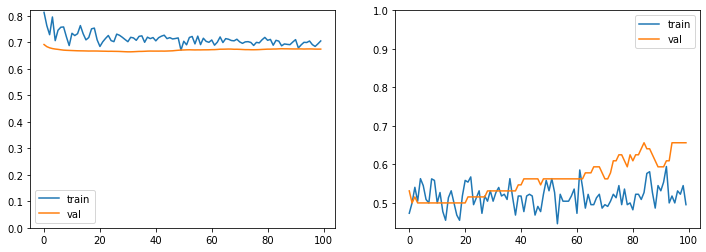

In [16]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)


list_model_files.append(file_model)

#### ~~4. Ink Marked/Creased~~

#### 5. Unnatural Skin Tone 

63 of 63
51 of 51
(90, 160, 160, 3) float32
(90,) int32
(24, 160, 160, 3) float32
(24,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 46s 462ms/step - loss: 91.1969 - val_loss: 137.9010
Epoch 2/100
100/100 [==============================] - 45s 449ms/step - loss: 67.5466 - val_loss: 152.9635
Epoch 3/100
100/100 [==============================] - 45s 450ms/step - loss: 58.5392 - val_loss: 145.8136
Epoch 4/100
100/100 [==============================] - 45s 450ms/step - loss: 46.9193 - val_loss: 137.8616
Epoch 5/100
100/100 [==============================] - 45s 450ms/step - loss: 30.0694 - val_loss: 136.2092
Epoch 6/100
100/100 [==============================] - 45s 450ms/step - loss: 22.4750 - val_loss: 136.9726
Epoch 7/100
100/100 [==============================] - 45s 450ms/step - loss: 20.4622 - val_loss: 134.1824
Epoch 8/100
100/100 [==============================] - 45s 450ms/step - loss: 18.7451 - val_loss: 135.1304
Epoch 9/100
100/100 [==============================] - 45s 450ms/step - loss: 16.2888 - val_loss: 134.7194
Epoch 10/100
100/100 [===============

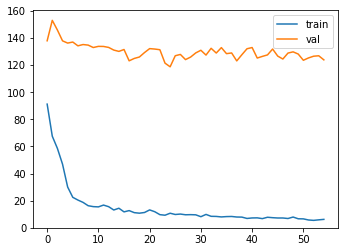

In [17]:
REQ_NAME = 'unnatural_skin_tone'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 2s 561ms/step - loss: 0.8701 - accuracy: 0.4896 - precision: 0.4896 - recall: 0.7007 - f1: 0.5746 - specificity: 0.2688 - negative_predictive_value: 0.4769 - matthews_correlation_coefficient: -0.0320 - equal_error_rate: 0.5415 - val_loss: 0.7040 - val_accuracy: 0.6250 - val_precision: 1.0000 - val_recall: 0.2500 - val_f1: 0.4000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.3780 - val_equal_error_rate: 0.4583

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.37796, saving model to ../../models/siamese_networks/unnatural_skin_tone_2020_06_13-02_13_13.h5
Epoch 2/100
3/3 [==============================] - 1s 206ms/step - loss: 0.8317 - accuracy: 0.4265 - precision: 0.4111 - recall: 0.5472 - f1: 0.4659 - specificity: 0.1997 - negative_predictive_value: 0.2778 - matthews_correlation_coefficient: -0.2801 - equal_error_rate: 0.3951 - val_loss: 0.7085 - val_

3/3 [==============================] - 0s 148ms/step - loss: 0.8191 - accuracy: 0.5147 - precision: 0.3565 - recall: 0.3968 - f1: 0.3740 - specificity: 0.4717 - negative_predictive_value: 0.4534 - matthews_correlation_coefficient: -0.1589 - equal_error_rate: 0.5098 - val_loss: 0.7164 - val_accuracy: 0.6250 - val_precision: 1.0000 - val_recall: 0.2500 - val_f1: 0.4000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.3780 - val_equal_error_rate: 0.4583

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.37796
Epoch 15/100
3/3 [==============================] - 0s 144ms/step - loss: 0.8872 - accuracy: 0.4853 - precision: 0.3095 - recall: 0.2997 - f1: 0.3037 - specificity: 0.3805 - negative_predictive_value: 0.3704 - matthews_correlation_coefficient: -0.3200 - equal_error_rate: 0.5533 - val_loss: 0.7142 - val_accuracy: 0.6250 - val_precision: 1.0000 - val_recall: 0.2500 - val_f1: 0.4000 - val_specificity: 1.00


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.37796
Epoch 28/100
3/3 [==============================] - 0s 126ms/step - loss: 0.6899 - accuracy: 0.6176 - precision: 0.7847 - recall: 0.5263 - f1: 0.6222 - specificity: 0.7885 - negative_predictive_value: 0.5889 - matthews_correlation_coefficient: 0.3421 - equal_error_rate: 0.3739 - val_loss: 0.7016 - val_accuracy: 0.6250 - val_precision: 1.0000 - val_recall: 0.2500 - val_f1: 0.4000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.3780 - val_equal_error_rate: 0.4583

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.37796
Epoch 29/100
3/3 [==============================] - 1s 167ms/step - loss: 0.8056 - accuracy: 0.4792 - precision: 0.4814 - recall: 0.5202 - f1: 0.4905 - specificity: 0.4576 - negative_predictive_value: 0.4974 - matthews_correlation_coefficient: -0.0217 - equal_error_rate: 0.5320 - val_loss: 0.7009 - val_accuracy: 

3/3 [==============================] - 0s 154ms/step - loss: 0.6598 - accuracy: 0.6250 - precision: 0.6142 - recall: 0.6415 - f1: 0.6269 - specificity: 0.5983 - negative_predictive_value: 0.6231 - matthews_correlation_coefficient: 0.2386 - equal_error_rate: 0.3640 - val_loss: 0.6978 - val_accuracy: 0.6250 - val_precision: 1.0000 - val_recall: 0.2500 - val_f1: 0.4000 - val_specificity: 1.0000 - val_negative_predictive_value: 0.5714 - val_matthews_correlation_coefficient: 0.3780 - val_equal_error_rate: 0.4583

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.37796
Epoch 42/100
3/3 [==============================] - 0s 152ms/step - loss: 0.8818 - accuracy: 0.4559 - precision: 0.3134 - recall: 0.3036 - f1: 0.3084 - specificity: 0.3212 - negative_predictive_value: 0.3120 - matthews_correlation_coefficient: -0.3749 - equal_error_rate: 0.5833 - val_loss: 0.6971 - val_accuracy: 0.6250 - val_precision: 1.0000 - val_recall: 0.2500 - val_f1: 0.4000 - val_specificity: 1.000

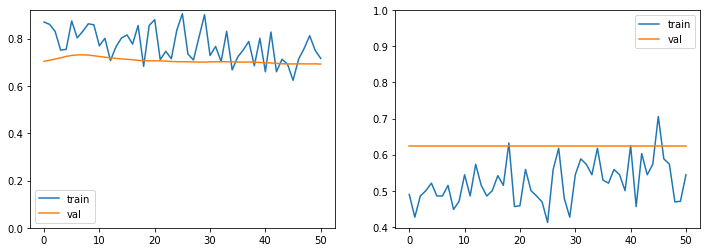

In [18]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 6. Too Dark/Light 

78 of 78
74 of 74
(121, 160, 160, 3) float32
(121,) int32
(31, 160, 160, 3) float32
(31,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 48s 478ms/step - loss: 91.2680 - val_loss: 75.3274
Epoch 2/100
100/100 [==============================] - 46s 464ms/step - loss: 76.9197 - val_loss: 103.8645
Epoch 3/100
100/100 [==============================] - 46s 464ms/step - loss: 64.9527 - val_loss: 116.0759
Epoch 4/100
100/100 [==============================] - 46s 464ms/step - loss: 55.5335 - val_loss: 135.3519
Epoch 5/100
100/100 [==============================] - 46s 464ms/step - loss: 41.6788 - val_loss: 137.4835
Epoch 6/100
100/100 [==============================] - 46s 463ms/step - loss: 32.9233 - val_loss: 132.4419
Epoch 7/100
100/100 [==============================] - 46s 464ms/step - loss: 25.0174 - val_loss: 127.2700
Epoch 8/100
100/100 [==============================] - 46s 464ms/step - loss: 21.4700 - val_loss: 129.1566
Epoch 9/100
100/100 [==============================] - 46s 464ms/step - loss: 19.0568 - val_loss: 124.7779
Epoch 10/100
100/100 [================

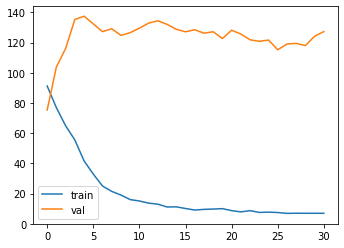

In [19]:
REQ_NAME = 'too_dark_light'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 2s 633ms/step - loss: 0.8158 - accuracy: 0.4583 - precision: 0.4633 - recall: 0.7119 - f1: 0.5503 - specificity: 0.2426 - negative_predictive_value: 0.4897 - matthews_correlation_coefficient: -0.0462 - equal_error_rate: 0.5212 - val_loss: 0.7529 - val_accuracy: 0.3871 - val_precision: 0.4348 - val_recall: 0.6250 - val_f1: 0.5128 - val_specificity: 0.1333 - val_negative_predictive_value: 0.2500 - val_matthews_correlation_coefficient: -0.2760 - val_equal_error_rate: 0.3542

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.27600, saving model to ../../models/siamese_networks/too_dark_light_2020_06_13-02_38_15.h5
Epoch 2/100
3/3 [==============================] - 1s 280ms/step - loss: 0.7955 - accuracy: 0.4457 - precision: 0.4894 - recall: 0.6726 - f1: 0.5647 - specificity: 0.1574 - negative_predictive_value: 0.2870 - matthews_correlation_coefficient: -0.1946 - equal_error_rate: 0.5307 - val_loss: 0.7437 - val_acc

3/3 [==============================] - 1s 186ms/step - loss: 0.7277 - accuracy: 0.5652 - precision: 0.5681 - recall: 0.8357 - f1: 0.6722 - specificity: 0.2407 - negative_predictive_value: 0.5556 - matthews_correlation_coefficient: 0.0966 - equal_error_rate: 0.4883 - val_loss: 0.6756 - val_accuracy: 0.4516 - val_precision: 0.4800 - val_recall: 0.7500 - val_f1: 0.5854 - val_specificity: 0.1333 - val_negative_predictive_value: 0.3333 - val_matthews_correlation_coefficient: -0.1476 - val_equal_error_rate: 0.2896

Epoch 00014: val_matthews_correlation_coefficient did not improve from -0.14757
Epoch 15/100
3/3 [==============================] - 1s 180ms/step - loss: 0.7392 - accuracy: 0.4348 - precision: 0.4354 - recall: 0.7798 - f1: 0.5565 - specificity: 0.1333 - negative_predictive_value: 0.4206 - matthews_correlation_coefficient: -0.1112 - equal_error_rate: 0.4158 - val_loss: 0.6722 - val_accuracy: 0.4516 - val_precision: 0.4800 - val_recall: 0.7500 - val_f1: 0.5854 - val_specificity: 0.1


Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.23395
Epoch 27/100
3/3 [==============================] - 1s 175ms/step - loss: 0.6804 - accuracy: 0.5000 - precision: 0.4795 - recall: 0.8065 - f1: 0.5960 - specificity: 0.2500 - negative_predictive_value: 0.5988 - matthews_correlation_coefficient: 0.0664 - equal_error_rate: 0.3112 - val_loss: 0.6465 - val_accuracy: 0.6452 - val_precision: 0.6190 - val_recall: 0.8125 - val_f1: 0.7027 - val_specificity: 0.4667 - val_negative_predictive_value: 0.7000 - val_matthews_correlation_coefficient: 0.2984 - val_equal_error_rate: 0.2250

Epoch 00027: val_matthews_correlation_coefficient improved from 0.23395 to 0.29844, saving model to ../../models/siamese_networks/too_dark_light_2020_06_13-02_38_15.h5
Epoch 28/100
3/3 [==============================] - 1s 177ms/step - loss: 0.6422 - accuracy: 0.6087 - precision: 0.6115 - recall: 0.8361 - f1: 0.6916 - specificity: 0.4111 - negative_predictive_value: 0.6593 - matthews_correl


Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.68826
Epoch 40/100
3/3 [==============================] - 1s 190ms/step - loss: 0.6517 - accuracy: 0.5652 - precision: 0.5530 - recall: 0.8444 - f1: 0.6615 - specificity: 0.2556 - negative_predictive_value: 0.7037 - matthews_correlation_coefficient: 0.1546 - equal_error_rate: 0.2847 - val_loss: 0.6321 - val_accuracy: 0.8387 - val_precision: 0.8235 - val_recall: 0.8750 - val_f1: 0.8485 - val_specificity: 0.8000 - val_negative_predictive_value: 0.8571 - val_matthews_correlation_coefficient: 0.6778 - val_equal_error_rate: 0.2250

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.68826
Epoch 41/100
3/3 [==============================] - 0s 167ms/step - loss: 0.6928 - accuracy: 0.5208 - precision: 0.4830 - recall: 0.7325 - f1: 0.5813 - specificity: 0.2685 - negative_predictive_value: 0.5000 - matthews_correlation_coefficient: -0.0065 - equal_error_rate: 0.4156 - val_loss: 0.6315 - val_accuracy: 

3/3 [==============================] - 1s 176ms/step - loss: 0.6800 - accuracy: 0.5521 - precision: 0.5236 - recall: 0.7968 - f1: 0.6234 - specificity: 0.3370 - negative_predictive_value: 0.6381 - matthews_correlation_coefficient: 0.1468 - equal_error_rate: 0.4380 - val_loss: 0.6220 - val_accuracy: 0.8065 - val_precision: 0.8571 - val_recall: 0.7500 - val_f1: 0.8000 - val_specificity: 0.8667 - val_negative_predictive_value: 0.7647 - val_matthews_correlation_coefficient: 0.6193 - val_equal_error_rate: 0.1604

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.68826
Epoch 54/100
3/3 [==============================] - 1s 171ms/step - loss: 0.6433 - accuracy: 0.5870 - precision: 0.5765 - recall: 0.8060 - f1: 0.6716 - specificity: 0.3056 - negative_predictive_value: 0.6040 - matthews_correlation_coefficient: 0.1420 - equal_error_rate: 0.3501 - val_loss: 0.6211 - val_accuracy: 0.8065 - val_precision: 0.8571 - val_recall: 0.7500 - val_f1: 0.8000 - val_specificity: 0.8667


Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.68826
Epoch 67/100
3/3 [==============================] - 1s 174ms/step - loss: 0.6514 - accuracy: 0.5870 - precision: 0.5296 - recall: 0.8075 - f1: 0.6381 - specificity: 0.3907 - negative_predictive_value: 0.7071 - matthews_correlation_coefficient: 0.2159 - equal_error_rate: 0.4327 - val_loss: 0.6086 - val_accuracy: 0.7742 - val_precision: 0.8462 - val_recall: 0.6875 - val_f1: 0.7586 - val_specificity: 0.8667 - val_negative_predictive_value: 0.7222 - val_matthews_correlation_coefficient: 0.5612 - val_equal_error_rate: 0.1604

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.68826
Epoch 68/100
3/3 [==============================] - 0s 167ms/step - loss: 0.6306 - accuracy: 0.6087 - precision: 0.5875 - recall: 0.7681 - f1: 0.6632 - specificity: 0.4167 - negative_predictive_value: 0.6492 - matthews_correlation_coefficient: 0.2082 - equal_error_rate: 0.3194 - val_loss: 0.6079 - val_accuracy: 0

3/3 [==============================] - 1s 169ms/step - loss: 0.5907 - accuracy: 0.6413 - precision: 0.6253 - recall: 0.7597 - f1: 0.6828 - specificity: 0.5000 - negative_predictive_value: 0.6472 - matthews_correlation_coefficient: 0.2658 - equal_error_rate: 0.3215 - val_loss: 0.6011 - val_accuracy: 0.7419 - val_precision: 0.8333 - val_recall: 0.6250 - val_f1: 0.7143 - val_specificity: 0.8667 - val_negative_predictive_value: 0.6842 - val_matthews_correlation_coefficient: 0.5044 - val_equal_error_rate: 0.1604

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.68826
Epoch 81/100
3/3 [==============================] - 1s 170ms/step - loss: 0.6847 - accuracy: 0.5104 - precision: 0.5074 - recall: 0.7270 - f1: 0.5773 - specificity: 0.3574 - negative_predictive_value: 0.5917 - matthews_correlation_coefficient: 0.0913 - equal_error_rate: 0.3335 - val_loss: 0.6004 - val_accuracy: 0.7419 - val_precision: 0.8333 - val_recall: 0.6250 - val_f1: 0.7143 - val_specificity: 0.8667

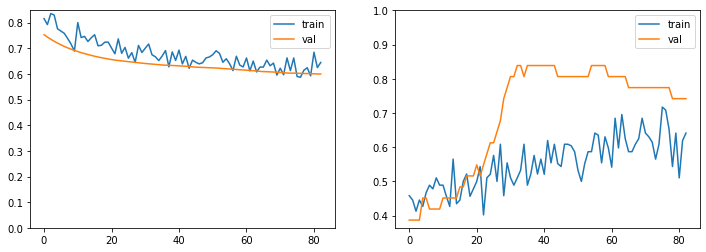

In [20]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 7. Washed Out

79 of 79
43 of 43
(97, 160, 160, 3) float32
(97,) int32
(25, 160, 160, 3) float32
(25,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 46s 459ms/step - loss: 100.5956 - val_loss: 98.4486
Epoch 2/100
100/100 [==============================] - 44s 442ms/step - loss: 99.1062 - val_loss: 96.6714
Epoch 3/100
100/100 [==============================] - 44s 443ms/step - loss: 95.5402 - val_loss: 96.7566
Epoch 4/100
100/100 [==============================] - 44s 443ms/step - loss: 92.4321 - val_loss: 81.7994
Epoch 5/100
100/100 [==============================] - 44s 443ms/step - loss: 88.6262 - val_loss: 45.5802
Epoch 6/100
100/100 [==============================] - 44s 443ms/step - loss: 88.3550 - val_loss: 50.0288
Epoch 7/100
100/100 [==============================] - 44s 443ms/step - loss: 83.2995 - val_loss: 34.6499
Epoch 8/100
100/100 [==============================] - 44s 443ms/step - loss: 77.7652 - val_loss: 36.3900
Epoch 9/100
100/100 [==============================] - 44s 443ms/step - loss: 73.6164 - val_loss: 43.3304
Epoch 10/100
100/100 [=======================

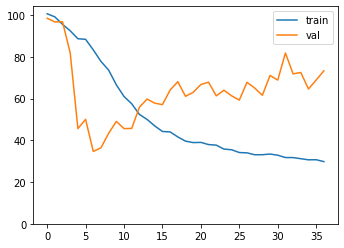

In [21]:
REQ_NAME = 'washed_out'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 2s 563ms/step - loss: 0.6513 - accuracy: 0.5729 - precision: 0.5540 - recall: 0.7008 - f1: 0.6170 - specificity: 0.4404 - negative_predictive_value: 0.5996 - matthews_correlation_coefficient: 0.1472 - equal_error_rate: 0.3642 - val_loss: 0.5991 - val_accuracy: 0.8000 - val_precision: 0.8333 - val_recall: 0.7692 - val_f1: 0.8000 - val_specificity: 0.8333 - val_negative_predictive_value: 0.7692 - val_matthews_correlation_coefficient: 0.6026 - val_equal_error_rate: 0.1987

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.60256, saving model to ../../models/siamese_networks/washed_out_2020_06_13-03_07_04.h5
Epoch 2/100
3/3 [==============================] - 1s 174ms/step - loss: 0.5509 - accuracy: 0.7128 - precision: 0.7228 - recall: 0.7649 - f1: 0.7391 - specificity: 0.6571 - negative_predictive_value: 0.7131 - matthews_correlation_coefficient: 0.4289 - equal_error_rate: 0.2313 - val_loss: 0.5874 - val_accuracy: 0

3/3 [==============================] - 0s 139ms/step - loss: 0.5273 - accuracy: 0.7340 - precision: 0.8821 - recall: 0.5802 - f1: 0.6988 - specificity: 0.9079 - negative_predictive_value: 0.6560 - matthews_correlation_coefficient: 0.5123 - equal_error_rate: 0.2734 - val_loss: 0.5050 - val_accuracy: 0.7600 - val_precision: 0.8182 - val_recall: 0.6923 - val_f1: 0.7500 - val_specificity: 0.8333 - val_negative_predictive_value: 0.7143 - val_matthews_correlation_coefficient: 0.5290 - val_equal_error_rate: 0.1987

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.60256
Epoch 15/100
3/3 [==============================] - 0s 153ms/step - loss: 0.5175 - accuracy: 0.7340 - precision: 0.7628 - recall: 0.6517 - f1: 0.6996 - specificity: 0.8187 - negative_predictive_value: 0.7181 - matthews_correlation_coefficient: 0.4756 - equal_error_rate: 0.2442 - val_loss: 0.5013 - val_accuracy: 0.7600 - val_precision: 0.8182 - val_recall: 0.6923 - val_f1: 0.7500 - val_specificity: 0.8333


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.60256
Epoch 28/100
3/3 [==============================] - 0s 147ms/step - loss: 0.4304 - accuracy: 0.8191 - precision: 0.8953 - recall: 0.7231 - f1: 0.7947 - specificity: 0.9251 - negative_predictive_value: 0.7733 - matthews_correlation_coefficient: 0.6583 - equal_error_rate: 0.1508 - val_loss: 0.4737 - val_accuracy: 0.8000 - val_precision: 0.8333 - val_recall: 0.7692 - val_f1: 0.8000 - val_specificity: 0.8333 - val_negative_predictive_value: 0.7692 - val_matthews_correlation_coefficient: 0.6026 - val_equal_error_rate: 0.1987

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.60256
Epoch 29/100
3/3 [==============================] - 0s 159ms/step - loss: 0.3964 - accuracy: 0.8333 - precision: 0.8434 - recall: 0.8098 - f1: 0.8261 - specificity: 0.8537 - negative_predictive_value: 0.8168 - matthews_correlation_coefficient: 0.6619 - equal_error_rate: 0.1770 - val_loss: 0.4721 - val_accuracy: 0

3/3 [==============================] - 0s 148ms/step - loss: 0.4272 - accuracy: 0.8438 - precision: 0.9040 - recall: 0.7624 - f1: 0.8238 - specificity: 0.9126 - negative_predictive_value: 0.8041 - matthews_correlation_coefficient: 0.6911 - equal_error_rate: 0.1977 - val_loss: 0.4612 - val_accuracy: 0.8000 - val_precision: 0.8333 - val_recall: 0.7692 - val_f1: 0.8000 - val_specificity: 0.8333 - val_negative_predictive_value: 0.7692 - val_matthews_correlation_coefficient: 0.6026 - val_equal_error_rate: 0.1987

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.60256
Epoch 42/100
3/3 [==============================] - 0s 146ms/step - loss: 0.4210 - accuracy: 0.8191 - precision: 0.8866 - recall: 0.7771 - f1: 0.8238 - specificity: 0.8651 - negative_predictive_value: 0.7721 - matthews_correlation_coefficient: 0.6502 - equal_error_rate: 0.2215 - val_loss: 0.4611 - val_accuracy: 0.8000 - val_precision: 0.8333 - val_recall: 0.7692 - val_f1: 0.8000 - val_specificity: 0.8333

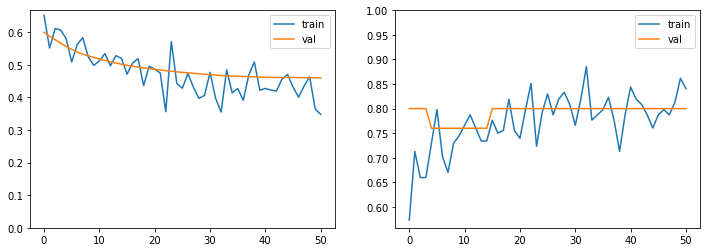

In [22]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 8. Pixelation

79 of 79
105 of 105
(147, 160, 160, 3) float32
(147,) int32
(37, 160, 160, 3) float32
(37,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 58s 580ms/step - loss: 98.9025 - val_loss: 97.5003
Epoch 2/100
100/100 [==============================] - 57s 567ms/step - loss: 97.0671 - val_loss: 93.7241
Epoch 3/100
100/100 [==============================] - 57s 567ms/step - loss: 96.1612 - val_loss: 88.8738
Epoch 4/100
100/100 [==============================] - 57s 567ms/step - loss: 95.9129 - val_loss: 83.5975
Epoch 5/100
100/100 [==============================] - 57s 567ms/step - loss: 92.6459 - val_loss: 81.4420
Epoch 6/100
100/100 [==============================] - 57s 567ms/step - loss: 93.6716 - val_loss: 80.1536
Epoch 7/100
100/100 [==============================] - 57s 567ms/step - loss: 92.8441 - val_loss: 80.9373
Epoch 8/100
100/100 [==============================] - 57s 567ms/step - loss: 91.3790 - val_loss: 79.9123
Epoch 9/100
100/100 [==============================] - 57s 567ms/step - loss: 90.5121 - val_loss: 79.3762
Epoch 10/100
100/100 [========================

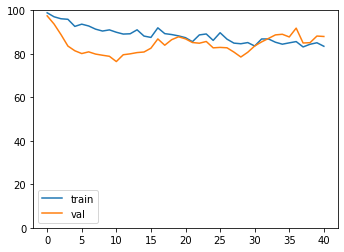

In [23]:
REQ_NAME = 'pixelation'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
5/5 [==============================] - 2s 405ms/step - loss: 0.7847 - accuracy: 0.4938 - precision: 0.4817 - recall: 0.5534 - f1: 0.5054 - specificity: 0.4544 - negative_predictive_value: 0.5141 - matthews_correlation_coefficient: 0.0020 - equal_error_rate: 0.5451 - val_loss: 0.9341 - val_accuracy: 0.4375 - val_precision: 0.4000 - val_recall: 0.1176 - val_f1: 0.1818 - val_specificity: 0.8000 - val_negative_predictive_value: 0.4444 - val_matthews_correlation_coefficient: -0.1132 - val_equal_error_rate: 0.6235

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.11318, saving model to ../../models/siamese_networks/pixelation_2020_06_13-03_47_04.h5
Epoch 2/100
5/5 [==============================] - 1s 181ms/step - loss: 0.7741 - accuracy: 0.4632 - precision: 0.4510 - recall: 0.5460 - f1: 0.4909 - specificity: 0.3370 - negative_predictive_value: 0.4084 - matthews_correlation_coefficient: -0.1283 - equal_error_rate: 0.4818 - val_loss: 0.9314 - val_accuracy

5/5 [==============================] - 1s 143ms/step - loss: 0.7576 - accuracy: 0.5000 - precision: 0.5228 - recall: 0.5777 - f1: 0.5456 - specificity: 0.4963 - negative_predictive_value: 0.5508 - matthews_correlation_coefficient: 0.0738 - equal_error_rate: 0.4549 - val_loss: 0.8222 - val_accuracy: 0.4062 - val_precision: 0.2500 - val_recall: 0.0588 - val_f1: 0.0952 - val_specificity: 0.8000 - val_negative_predictive_value: 0.4286 - val_matthews_correlation_coefficient: -0.2130 - val_equal_error_rate: 0.6824

Epoch 00014: val_matthews_correlation_coefficient did not improve from -0.11318
Epoch 15/100
5/5 [==============================] - 1s 147ms/step - loss: 0.7348 - accuracy: 0.5515 - precision: 0.5418 - recall: 0.5761 - f1: 0.5365 - specificity: 0.5030 - negative_predictive_value: 0.5400 - matthews_correlation_coefficient: 0.0804 - equal_error_rate: 0.4367 - val_loss: 0.8149 - val_accuracy: 0.4062 - val_precision: 0.2500 - val_recall: 0.0588 - val_f1: 0.0952 - val_specificity: 0.80


Epoch 00027: val_matthews_correlation_coefficient did not improve from -0.11318
Epoch 28/100
5/5 [==============================] - 1s 150ms/step - loss: 0.7246 - accuracy: 0.5147 - precision: 0.5307 - recall: 0.5617 - f1: 0.5414 - specificity: 0.4796 - negative_predictive_value: 0.5166 - matthews_correlation_coefficient: 0.0441 - equal_error_rate: 0.5347 - val_loss: 0.7673 - val_accuracy: 0.3750 - val_precision: 0.2857 - val_recall: 0.1176 - val_f1: 0.1667 - val_specificity: 0.6667 - val_negative_predictive_value: 0.4000 - val_matthews_correlation_coefficient: -0.2604 - val_equal_error_rate: 0.5608

Epoch 00028: val_matthews_correlation_coefficient did not improve from -0.11318
Epoch 29/100
5/5 [==============================] - 1s 154ms/step - loss: 0.7086 - accuracy: 0.4926 - precision: 0.5274 - recall: 0.5107 - f1: 0.5083 - specificity: 0.4945 - negative_predictive_value: 0.4779 - matthews_correlation_coefficient: 0.0052 - equal_error_rate: 0.4551 - val_loss: 0.7639 - val_accuracy

5/5 [==============================] - 1s 155ms/step - loss: 0.7309 - accuracy: 0.4926 - precision: 0.4987 - recall: 0.5176 - f1: 0.5043 - specificity: 0.4278 - negative_predictive_value: 0.4500 - matthews_correlation_coefficient: -0.0529 - equal_error_rate: 0.5216 - val_loss: 0.7576 - val_accuracy: 0.4062 - val_precision: 0.4167 - val_recall: 0.2941 - val_f1: 0.3448 - val_specificity: 0.5333 - val_negative_predictive_value: 0.4000 - val_matthews_correlation_coefficient: -0.1779 - val_equal_error_rate: 0.5608

Epoch 00041: val_matthews_correlation_coefficient did not improve from -0.04222
Epoch 42/100
5/5 [==============================] - 1s 163ms/step - loss: 0.6938 - accuracy: 0.5515 - precision: 0.5728 - recall: 0.5990 - f1: 0.5751 - specificity: 0.4740 - negative_predictive_value: 0.5080 - matthews_correlation_coefficient: 0.0767 - equal_error_rate: 0.4543 - val_loss: 0.7550 - val_accuracy: 0.4062 - val_precision: 0.4375 - val_recall: 0.4118 - val_f1: 0.4242 - val_specificity: 0.4

5/5 [==============================] - 1s 163ms/step - loss: 0.7039 - accuracy: 0.5294 - precision: 0.5452 - recall: 0.5922 - f1: 0.5634 - specificity: 0.3949 - negative_predictive_value: 0.4198 - matthews_correlation_coefficient: -0.0234 - equal_error_rate: 0.4420 - val_loss: 0.7435 - val_accuracy: 0.5625 - val_precision: 0.5714 - val_recall: 0.7059 - val_f1: 0.6316 - val_specificity: 0.4000 - val_negative_predictive_value: 0.5455 - val_matthews_correlation_coefficient: 0.1112 - val_equal_error_rate: 0.6824

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.17732
Epoch 55/100
5/5 [==============================] - 1s 169ms/step - loss: 0.6927 - accuracy: 0.5312 - precision: 0.5200 - recall: 0.6479 - f1: 0.5751 - specificity: 0.4082 - negative_predictive_value: 0.5324 - matthews_correlation_coefficient: 0.0543 - equal_error_rate: 0.4443 - val_loss: 0.7413 - val_accuracy: 0.5625 - val_precision: 0.5714 - val_recall: 0.7059 - val_f1: 0.6316 - val_specificity: 0.400


Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.17732
Epoch 68/100
5/5 [==============================] - 1s 151ms/step - loss: 0.6944 - accuracy: 0.5882 - precision: 0.6456 - recall: 0.5884 - f1: 0.5568 - specificity: 0.6044 - negative_predictive_value: 0.5901 - matthews_correlation_coefficient: 0.2100 - equal_error_rate: 0.3998 - val_loss: 0.7354 - val_accuracy: 0.5625 - val_precision: 0.5714 - val_recall: 0.7059 - val_f1: 0.6316 - val_specificity: 0.4000 - val_negative_predictive_value: 0.5455 - val_matthews_correlation_coefficient: 0.1112 - val_equal_error_rate: 0.6235

Epoch 00068: val_matthews_correlation_coefficient did not improve from 0.17732
Epoch 69/100
5/5 [==============================] - 1s 154ms/step - loss: 0.6877 - accuracy: 0.5956 - precision: 0.6220 - recall: 0.6362 - f1: 0.6220 - specificity: 0.5970 - negative_predictive_value: 0.6077 - matthews_correlation_coefficient: 0.2315 - equal_error_rate: 0.4347 - val_loss: 0.7359 - val_accuracy: 0

5/5 [==============================] - 1s 151ms/step - loss: 0.6864 - accuracy: 0.5515 - precision: 0.6320 - recall: 0.6055 - f1: 0.5846 - specificity: 0.5547 - negative_predictive_value: 0.5479 - matthews_correlation_coefficient: 0.1695 - equal_error_rate: 0.4361 - val_loss: 0.7295 - val_accuracy: 0.5625 - val_precision: 0.5714 - val_recall: 0.7059 - val_f1: 0.6316 - val_specificity: 0.4000 - val_negative_predictive_value: 0.5455 - val_matthews_correlation_coefficient: 0.1112 - val_equal_error_rate: 0.6196

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.17732
Epoch 82/100
5/5 [==============================] - 1s 151ms/step - loss: 0.7049 - accuracy: 0.5368 - precision: 0.4913 - recall: 0.5553 - f1: 0.5135 - specificity: 0.4443 - negative_predictive_value: 0.5096 - matthews_correlation_coefficient: 2.3678e-04 - equal_error_rate: 0.5088 - val_loss: 0.7282 - val_accuracy: 0.5625 - val_precision: 0.5714 - val_recall: 0.7059 - val_f1: 0.6316 - val_specificity: 0.


Epoch 00094: val_matthews_correlation_coefficient did not improve from 0.17732
Epoch 95/100
5/5 [==============================] - 1s 156ms/step - loss: 0.6632 - accuracy: 0.6250 - precision: 0.6729 - recall: 0.7021 - f1: 0.6713 - specificity: 0.5965 - negative_predictive_value: 0.6348 - matthews_correlation_coefficient: 0.3030 - equal_error_rate: 0.3861 - val_loss: 0.7217 - val_accuracy: 0.5312 - val_precision: 0.5455 - val_recall: 0.7059 - val_f1: 0.6154 - val_specificity: 0.3333 - val_negative_predictive_value: 0.5000 - val_matthews_correlation_coefficient: 0.0422 - val_equal_error_rate: 0.5902

Epoch 00095: val_matthews_correlation_coefficient did not improve from 0.17732
Epoch 96/100
5/5 [==============================] - 1s 152ms/step - loss: 0.6770 - accuracy: 0.5662 - precision: 0.5981 - recall: 0.6647 - f1: 0.6245 - specificity: 0.4785 - negative_predictive_value: 0.5476 - matthews_correlation_coefficient: 0.1444 - equal_error_rate: 0.3984 - val_loss: 0.7218 - val_accuracy: 0

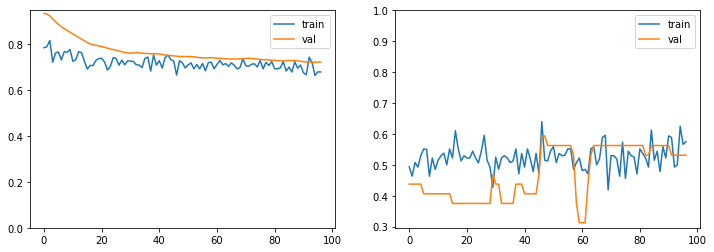

In [24]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 9. Hair Across Eyes 

181 of 181
179 of 179
(287, 160, 160, 3) float32
(287,) int32
(73, 160, 160, 3) float32
(73,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 59s 593ms/step - loss: 97.5696 - val_loss: 93.2848
Epoch 2/100
100/100 [==============================] - 57s 566ms/step - loss: 93.7539 - val_loss: 91.8622
Epoch 3/100
100/100 [==============================] - 57s 568ms/step - loss: 92.7082 - val_loss: 93.6368
Epoch 4/100
100/100 [==============================] - 57s 568ms/step - loss: 90.5404 - val_loss: 94.3191
Epoch 5/100
100/100 [==============================] - 57s 566ms/step - loss: 87.6969 - val_loss: 96.7020
Epoch 6/100
100/100 [==============================] - 57s 565ms/step - loss: 85.7682 - val_loss: 100.1448
Epoch 7/100
100/100 [==============================] - 57s 569ms/step - loss: 84.8301 - val_loss: 104.6175
Epoch 8/100
100/100 [==============================] - 57s 568ms/step - loss: 81.8580 - val_loss: 101.6242
Epoch 9/100
100/100 [==============================] - 57s 571ms/step - loss: 78.3672 - val_loss: 106.8485
Epoch 10/100
100/100 [====================

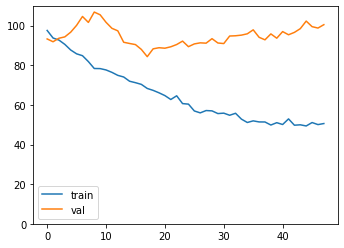

In [25]:
REQ_NAME = 'hair_across_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
9/9 [==============================] - 3s 314ms/step - loss: 0.8051 - accuracy: 0.4931 - precision: 0.4923 - recall: 0.6076 - f1: 0.5368 - specificity: 0.3584 - negative_predictive_value: 0.4775 - matthews_correlation_coefficient: -0.0320 - equal_error_rate: 0.5383 - val_loss: 0.6394 - val_accuracy: 0.6406 - val_precision: 0.6962 - val_recall: 0.4980 - val_f1: 0.5800 - val_specificity: 0.7784 - val_negative_predictive_value: 0.6077 - val_matthews_correlation_coefficient: 0.2897 - val_equal_error_rate: 0.3284

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28970, saving model to ../../models/siamese_networks/hair_across_eyes_2020_06_13-04_35_06.h5
Epoch 2/100
9/9 [==============================] - 1s 154ms/step - loss: 0.7957 - accuracy: 0.4861 - precision: 0.4960 - recall: 0.5972 - f1: 0.5289 - specificity: 0.3862 - negative_predictive_value: 0.4875 - matthews_correlation_coefficient: -0.0163 - equal_error_rate: 0.4844 - val_loss: 0.6504 - val_acc

9/9 [==============================] - 2s 173ms/step - loss: 0.7201 - accuracy: 0.5451 - precision: 0.5677 - recall: 0.5227 - f1: 0.5262 - specificity: 0.6004 - negative_predictive_value: 0.5518 - matthews_correlation_coefficient: 0.1213 - equal_error_rate: 0.4485 - val_loss: 0.7330 - val_accuracy: 0.5625 - val_precision: 0.5855 - val_recall: 0.4020 - val_f1: 0.4750 - val_specificity: 0.7157 - val_negative_predictive_value: 0.5458 - val_matthews_correlation_coefficient: 0.1241 - val_equal_error_rate: 0.4853

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.28970
Epoch 15/100
9/9 [==============================] - 2s 177ms/step - loss: 0.6920 - accuracy: 0.5694 - precision: 0.5648 - recall: 0.6024 - f1: 0.5720 - specificity: 0.5366 - negative_predictive_value: 0.5827 - matthews_correlation_coefficient: 0.1429 - equal_error_rate: 0.4567 - val_loss: 0.7413 - val_accuracy: 0.5625 - val_precision: 0.5855 - val_recall: 0.4020 - val_f1: 0.4750 - val_specificity: 0.7157


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.28970
Epoch 28/100
9/9 [==============================] - 2s 173ms/step - loss: 0.6614 - accuracy: 0.6215 - precision: 0.6223 - recall: 0.6008 - f1: 0.6021 - specificity: 0.6433 - negative_predictive_value: 0.6140 - matthews_correlation_coefficient: 0.2400 - equal_error_rate: 0.3652 - val_loss: 0.8105 - val_accuracy: 0.4062 - val_precision: 0.4286 - val_recall: 0.5647 - val_f1: 0.4868 - val_specificity: 0.2471 - val_negative_predictive_value: 0.3636 - val_matthews_correlation_coefficient: -0.1978 - val_equal_error_rate: 0.4853

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.28970
Epoch 29/100
9/9 [==============================] - 2s 178ms/step - loss: 0.6836 - accuracy: 0.5486 - precision: 0.5342 - recall: 0.5556 - f1: 0.5346 - specificity: 0.5194 - negative_predictive_value: 0.5467 - matthews_correlation_coefficient: 0.0780 - equal_error_rate: 0.4403 - val_loss: 0.8135 - val_accuracy: 

9/9 [==============================] - 2s 174ms/step - loss: 0.6819 - accuracy: 0.6042 - precision: 0.6198 - recall: 0.5148 - f1: 0.5464 - specificity: 0.6914 - negative_predictive_value: 0.5882 - matthews_correlation_coefficient: 0.2063 - equal_error_rate: 0.4096 - val_loss: 0.8515 - val_accuracy: 0.3750 - val_precision: 0.4125 - val_recall: 0.5647 - val_f1: 0.4740 - val_specificity: 0.1922 - val_negative_predictive_value: 0.2917 - val_matthews_correlation_coefficient: -0.2678 - val_equal_error_rate: 0.5000

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.28970
Epoch 42/100
9/9 [==============================] - 2s 181ms/step - loss: 0.6527 - accuracy: 0.6042 - precision: 0.6059 - recall: 0.5289 - f1: 0.5595 - specificity: 0.6674 - negative_predictive_value: 0.5836 - matthews_correlation_coefficient: 0.1926 - equal_error_rate: 0.4106 - val_loss: 0.8527 - val_accuracy: 0.3750 - val_precision: 0.4125 - val_recall: 0.5647 - val_f1: 0.4740 - val_specificity: 0.192

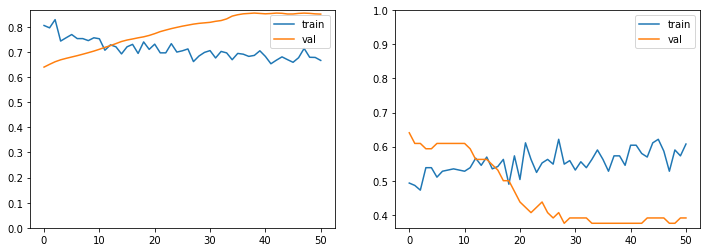

In [26]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 10. Eyes Closed  

123 of 123
77 of 77
(159, 160, 160, 3) float32
(159,) int32
(41, 160, 160, 3) float32
(41,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 58s 584ms/step - loss: 94.6456 - val_loss: 106.5893
Epoch 2/100
100/100 [==============================] - 57s 570ms/step - loss: 87.2683 - val_loss: 104.3654
Epoch 3/100
100/100 [==============================] - 57s 571ms/step - loss: 81.3197 - val_loss: 97.2184
Epoch 4/100
100/100 [==============================] - 57s 568ms/step - loss: 75.3301 - val_loss: 92.4540
Epoch 5/100
100/100 [==============================] - 57s 568ms/step - loss: 73.5582 - val_loss: 97.4339
Epoch 6/100
100/100 [==============================] - 57s 568ms/step - loss: 69.2181 - val_loss: 98.5200
Epoch 7/100
100/100 [==============================] - 57s 569ms/step - loss: 66.8492 - val_loss: 95.7946
Epoch 8/100
100/100 [==============================] - 57s 568ms/step - loss: 62.8604 - val_loss: 96.9943
Epoch 9/100
100/100 [==============================] - 57s 568ms/step - loss: 61.6486 - val_loss: 100.8639
Epoch 10/100
100/100 [=====================

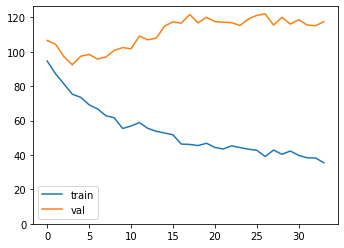

In [27]:
REQ_NAME = 'eyes_closed'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
6/6 [==============================] - 3s 428ms/step - loss: 0.7672 - accuracy: 0.5156 - precision: 0.5170 - recall: 0.7042 - f1: 0.5868 - specificity: 0.3528 - negative_predictive_value: 0.5418 - matthews_correlation_coefficient: 0.0582 - equal_error_rate: 0.4907 - val_loss: 0.7530 - val_accuracy: 0.4688 - val_precision: 0.4444 - val_recall: 0.8571 - val_f1: 0.5854 - val_specificity: 0.1667 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.0325 - val_equal_error_rate: 0.5635

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.03253, saving model to ../../models/siamese_networks/eyes_closed_2020_06_13-05_09_51.h5
Epoch 2/100
6/6 [==============================] - 1s 157ms/step - loss: 0.8315 - accuracy: 0.4207 - precision: 0.3744 - recall: 0.4556 - f1: 0.4024 - specificity: 0.2748 - negative_predictive_value: 0.3184 - matthews_correlation_coefficient: -0.2858 - equal_error_rate: 0.5939 - val_loss: 0.7481 - val_accuracy:

6/6 [==============================] - 1s 184ms/step - loss: 0.7623 - accuracy: 0.4756 - precision: 0.5320 - recall: 0.7112 - f1: 0.6030 - specificity: 0.2250 - negative_predictive_value: 0.3289 - matthews_correlation_coefficient: -0.0790 - equal_error_rate: 0.4906 - val_loss: 0.7341 - val_accuracy: 0.4375 - val_precision: 0.4286 - val_recall: 0.8571 - val_f1: 0.5714 - val_specificity: 0.1111 - val_negative_predictive_value: 0.5000 - val_matthews_correlation_coefficient: -0.0476 - val_equal_error_rate: 0.5357

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.03253
Epoch 15/100
6/6 [==============================] - 1s 210ms/step - loss: 0.7439 - accuracy: 0.4688 - precision: 0.4740 - recall: 0.5813 - f1: 0.5157 - specificity: 0.3644 - negative_predictive_value: 0.4645 - matthews_correlation_coefficient: -0.0577 - equal_error_rate: 0.4889 - val_loss: 0.7317 - val_accuracy: 0.4375 - val_precision: 0.4286 - val_recall: 0.8571 - val_f1: 0.5714 - val_specificity: 0.1

6/6 [==============================] - 1s 177ms/step - loss: 0.7047 - accuracy: 0.5854 - precision: 0.5995 - recall: 0.8456 - f1: 0.6985 - specificity: 0.2759 - negative_predictive_value: 0.5188 - matthews_correlation_coefficient: 0.1390 - equal_error_rate: 0.4245 - val_loss: 0.7318 - val_accuracy: 0.4375 - val_precision: 0.4375 - val_recall: 1.0000 - val_f1: 0.6087 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: 0.0000e+00 - val_equal_error_rate: 0.5635

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.03253
Epoch 28/100
6/6 [==============================] - 1s 188ms/step - loss: 0.7060 - accuracy: 0.5061 - precision: 0.5351 - recall: 0.7338 - f1: 0.6116 - specificity: 0.2201 - negative_predictive_value: 0.4230 - matthews_correlation_coefficient: -0.0440 - equal_error_rate: 0.4135 - val_loss: 0.7307 - val_accuracy: 0.4062 - val_precision: 0.4194 - val_recall: 0.9286 - val_f1: 0.5778 - val_specif

6/6 [==============================] - 1s 174ms/step - loss: 0.6666 - accuracy: 0.5732 - precision: 0.6251 - recall: 0.7617 - f1: 0.6774 - specificity: 0.5218 - negative_predictive_value: 0.6658 - matthews_correlation_coefficient: 0.2870 - equal_error_rate: 0.4449 - val_loss: 0.7264 - val_accuracy: 0.3125 - val_precision: 0.3462 - val_recall: 0.6429 - val_f1: 0.4500 - val_specificity: 0.0556 - val_negative_predictive_value: 0.1667 - val_matthews_correlation_coefficient: -0.3833 - val_equal_error_rate: 0.6270

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.03253
Epoch 41/100
6/6 [==============================] - 1s 180ms/step - loss: 0.7014 - accuracy: 0.5671 - precision: 0.5636 - recall: 0.6006 - f1: 0.5752 - specificity: 0.4083 - negative_predictive_value: 0.4806 - matthews_correlation_coefficient: 0.0275 - equal_error_rate: 0.4455 - val_loss: 0.7264 - val_accuracy: 0.3125 - val_precision: 0.3462 - val_recall: 0.6429 - val_f1: 0.4500 - val_specificity: 0.055

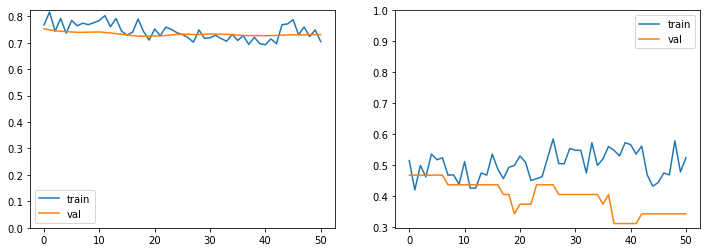

In [28]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 11. Varied Background

130 of 130
150 of 150
(224, 160, 160, 3) float32
(224,) int32
(56, 160, 160, 3) float32
(56,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 69s 691ms/step - loss: 92.0382 - val_loss: 69.2741
Epoch 2/100
100/100 [==============================] - 70s 701ms/step - loss: 75.8283 - val_loss: 65.3978
Epoch 3/100
100/100 [==============================] - 71s 705ms/step - loss: 59.7737 - val_loss: 58.5143
Epoch 4/100
100/100 [==============================] - 70s 696ms/step - loss: 36.9789 - val_loss: 50.1363
Epoch 5/100
100/100 [==============================] - 70s 700ms/step - loss: 27.2230 - val_loss: 47.6975
Epoch 6/100
100/100 [==============================] - 70s 705ms/step - loss: 22.2014 - val_loss: 49.8415
Epoch 7/100
100/100 [==============================] - 70s 696ms/step - loss: 19.1099 - val_loss: 35.8881
Epoch 8/100
100/100 [==============================] - 70s 700ms/step - loss: 17.3397 - val_loss: 27.7488
Epoch 9/100
100/100 [==============================] - 71s 710ms/step - loss: 16.4856 - val_loss: 38.6672
Epoch 10/100
100/100 [========================

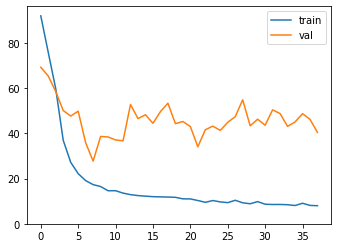

In [29]:
REQ_NAME = 'varied_background'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 3s 380ms/step - loss: 0.7410 - accuracy: 0.5312 - precision: 0.5366 - recall: 0.4866 - f1: 0.5016 - specificity: 0.5866 - negative_predictive_value: 0.5381 - matthews_correlation_coefficient: 0.0739 - equal_error_rate: 0.4680 - val_loss: 0.6922 - val_accuracy: 0.6875 - val_precision: 0.8750 - val_recall: 0.4375 - val_f1: 0.5833 - val_specificity: 0.9375 - val_negative_predictive_value: 0.6250 - val_matthews_correlation_coefficient: 0.4330 - val_equal_error_rate: 0.4062

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.43301, saving model to ../../models/siamese_networks/varied_background_2020_06_13-05_56_29.h5
Epoch 2/100
7/7 [==============================] - 1s 129ms/step - loss: 0.7366 - accuracy: 0.5577 - precision: 0.5810 - recall: 0.5015 - f1: 0.5301 - specificity: 0.6210 - negative_predictive_value: 0.5452 - matthews_correlation_coefficient: 0.1243 - equal_error_rate: 0.4372 - val_loss: 0.6566 - val_accu


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.87500
Epoch 14/100
7/7 [==============================] - 2s 221ms/step - loss: 0.5745 - accuracy: 0.6827 - precision: 0.7187 - recall: 0.5465 - f1: 0.6182 - specificity: 0.7915 - negative_predictive_value: 0.6416 - matthews_correlation_coefficient: 0.3487 - equal_error_rate: 0.3088 - val_loss: 0.4034 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375 - val_f1: 0.9375 - val_specificity: 0.9375 - val_negative_predictive_value: 0.9375 - val_matthews_correlation_coefficient: 0.8750 - val_equal_error_rate: 0.1250

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.87500
Epoch 15/100
7/7 [==============================] - 2s 227ms/step - loss: 0.5877 - accuracy: 0.6875 - precision: 0.7203 - recall: 0.6609 - f1: 0.6741 - specificity: 0.7200 - negative_predictive_value: 0.6758 - matthews_correlation_coefficient: 0.3882 - equal_error_rate: 0.3257 - val_loss: 0.3936 - val_accuracy: 0

7/7 [==============================] - 2s 221ms/step - loss: 0.5707 - accuracy: 0.7404 - precision: 0.7829 - recall: 0.6325 - f1: 0.6946 - specificity: 0.8371 - negative_predictive_value: 0.7013 - matthews_correlation_coefficient: 0.4767 - equal_error_rate: 0.2730 - val_loss: 0.3225 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375 - val_f1: 0.9375 - val_specificity: 0.9375 - val_negative_predictive_value: 0.9375 - val_matthews_correlation_coefficient: 0.8750 - val_equal_error_rate: 0.0938

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.87500
Epoch 28/100
7/7 [==============================] - 2s 226ms/step - loss: 0.5667 - accuracy: 0.7115 - precision: 0.7273 - recall: 0.6798 - f1: 0.6872 - specificity: 0.7283 - negative_predictive_value: 0.7140 - matthews_correlation_coefficient: 0.4239 - equal_error_rate: 0.2868 - val_loss: 0.3181 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375 - val_f1: 0.9375 - val_specificity: 0.9375


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.87500
Epoch 41/100
7/7 [==============================] - 2s 238ms/step - loss: 0.4798 - accuracy: 0.7723 - precision: 0.8219 - recall: 0.7060 - f1: 0.7543 - specificity: 0.8334 - negative_predictive_value: 0.7367 - matthews_correlation_coefficient: 0.5488 - equal_error_rate: 0.2361 - val_loss: 0.2813 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375 - val_f1: 0.9375 - val_specificity: 0.9375 - val_negative_predictive_value: 0.9375 - val_matthews_correlation_coefficient: 0.8750 - val_equal_error_rate: 0.0938

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.87500
Epoch 42/100
7/7 [==============================] - 2s 225ms/step - loss: 0.6120 - accuracy: 0.6779 - precision: 0.7322 - recall: 0.6191 - f1: 0.6578 - specificity: 0.7412 - negative_predictive_value: 0.6566 - matthews_correlation_coefficient: 0.3740 - equal_error_rate: 0.3298 - val_loss: 0.2784 - val_accuracy: 0

7/7 [==============================] - 2s 222ms/step - loss: 0.5206 - accuracy: 0.7644 - precision: 0.7828 - recall: 0.6737 - f1: 0.7221 - specificity: 0.8231 - negative_predictive_value: 0.7262 - matthews_correlation_coefficient: 0.5027 - equal_error_rate: 0.2364 - val_loss: 0.2610 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375 - val_f1: 0.9375 - val_specificity: 0.9375 - val_negative_predictive_value: 0.9375 - val_matthews_correlation_coefficient: 0.8750 - val_equal_error_rate: 0.0938

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.87500
Epoch 55/100
7/7 [==============================] - 2s 228ms/step - loss: 0.4861 - accuracy: 0.7740 - precision: 0.8048 - recall: 0.7104 - f1: 0.7528 - specificity: 0.8169 - negative_predictive_value: 0.7275 - matthews_correlation_coefficient: 0.5296 - equal_error_rate: 0.2365 - val_loss: 0.2597 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375 - val_f1: 0.9375 - val_specificity: 0.9375

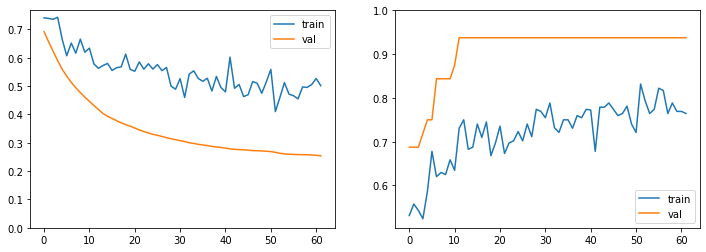

In [30]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 12. Roll/pitch/yaw

150 of 150
141 of 141
(232, 160, 160, 3) float32
(232,) int32
(59, 160, 160, 3) float32
(59,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 80s 803ms/step - loss: 99.5148 - val_loss: 97.8958
Epoch 2/100
100/100 [==============================] - 74s 744ms/step - loss: 98.2247 - val_loss: 91.3999
Epoch 3/100
100/100 [==============================] - 75s 749ms/step - loss: 97.2464 - val_loss: 87.1781
Epoch 4/100
100/100 [==============================] - 74s 739ms/step - loss: 97.3365 - val_loss: 86.0128
Epoch 5/100
100/100 [==============================] - 74s 744ms/step - loss: 96.4327 - val_loss: 85.2702
Epoch 6/100
100/100 [==============================] - 75s 749ms/step - loss: 95.1873 - val_loss: 84.9639
Epoch 7/100
100/100 [==============================] - 74s 739ms/step - loss: 95.0489 - val_loss: 83.7161
Epoch 8/100
100/100 [==============================] - 75s 747ms/step - loss: 95.0317 - val_loss: 79.9242
Epoch 9/100
100/100 [==============================] - 75s 753ms/step - loss: 93.8179 - val_loss: 80.5633
Epoch 10/100
100/100 [========================

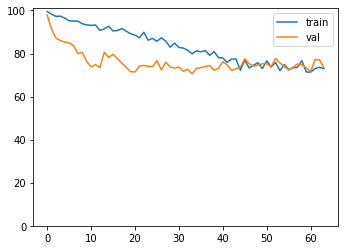

In [31]:
REQ_NAME = 'roll_pitch_yaw'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 3s 437ms/step - loss: 0.8519 - accuracy: 0.5134 - precision: 0.5138 - recall: 0.8291 - f1: 0.6326 - specificity: 0.1897 - negative_predictive_value: 0.5340 - matthews_correlation_coefficient: 0.0307 - equal_error_rate: 0.5129 - val_loss: 0.7972 - val_accuracy: 0.3750 - val_precision: 0.3871 - val_recall: 0.9231 - val_f1: 0.5455 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.2171 - val_equal_error_rate: 0.5972

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.21713, saving model to ../../models/siamese_networks/roll_pitch_yaw_2020_06_13-07_19_15.h5
Epoch 2/100
7/7 [==============================] - 1s 154ms/step - loss: 0.7982 - accuracy: 0.4760 - precision: 0.4700 - recall: 0.6404 - f1: 0.5402 - specificity: 0.3039 - negative_predictive_value: 0.4683 - matthews_correlation_coefficient: -0.0585 - equal_error_rate: 0.4972 - val_loss: 0.7434 - 


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.25715
Epoch 14/100
7/7 [==============================] - 2s 235ms/step - loss: 0.7053 - accuracy: 0.5817 - precision: 0.5682 - recall: 0.6295 - f1: 0.5871 - specificity: 0.5431 - negative_predictive_value: 0.6113 - matthews_correlation_coefficient: 0.1760 - equal_error_rate: 0.4117 - val_loss: 0.6926 - val_accuracy: 0.5625 - val_precision: 0.4545 - val_recall: 0.3846 - val_f1: 0.4167 - val_specificity: 0.6842 - val_negative_predictive_value: 0.6190 - val_matthews_correlation_coefficient: 0.0712 - val_equal_error_rate: 0.4413

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.25715
Epoch 15/100
7/7 [==============================] - 2s 235ms/step - loss: 0.7428 - accuracy: 0.5000 - precision: 0.4958 - recall: 0.4987 - f1: 0.4936 - specificity: 0.5171 - negative_predictive_value: 0.5191 - matthews_correlation_coefficient: 0.0154 - equal_error_rate: 0.4886 - val_loss: 0.6906 - val_accuracy: 0

7/7 [==============================] - 2s 234ms/step - loss: 0.7137 - accuracy: 0.5577 - precision: 0.5923 - recall: 0.5076 - f1: 0.5284 - specificity: 0.6512 - negative_predictive_value: 0.5801 - matthews_correlation_coefficient: 0.1650 - equal_error_rate: 0.4184 - val_loss: 0.6956 - val_accuracy: 0.5000 - val_precision: 0.2857 - val_recall: 0.1538 - val_f1: 0.2000 - val_specificity: 0.7368 - val_negative_predictive_value: 0.5600 - val_matthews_correlation_coefficient: -0.1299 - val_equal_error_rate: 0.4413

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.25715
Epoch 28/100
7/7 [==============================] - 2s 234ms/step - loss: 0.7281 - accuracy: 0.5481 - precision: 0.5418 - recall: 0.4967 - f1: 0.5156 - specificity: 0.5885 - negative_predictive_value: 0.5452 - matthews_correlation_coefficient: 0.0861 - equal_error_rate: 0.4962 - val_loss: 0.6959 - val_accuracy: 0.5000 - val_precision: 0.2857 - val_recall: 0.1538 - val_f1: 0.2000 - val_specificity: 0.736


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.25715
Epoch 41/100
7/7 [==============================] - 2s 256ms/step - loss: 0.6897 - accuracy: 0.5580 - precision: 0.5581 - recall: 0.4798 - f1: 0.5062 - specificity: 0.6330 - negative_predictive_value: 0.5548 - matthews_correlation_coefficient: 0.1128 - equal_error_rate: 0.4377 - val_loss: 0.6910 - val_accuracy: 0.5938 - val_precision: 0.5000 - val_recall: 0.2308 - val_f1: 0.3158 - val_specificity: 0.8421 - val_negative_predictive_value: 0.6154 - val_matthews_correlation_coefficient: 0.0917 - val_equal_error_rate: 0.4413

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.25715
Epoch 42/100
7/7 [==============================] - 2s 235ms/step - loss: 0.7470 - accuracy: 0.5096 - precision: 0.4926 - recall: 0.4985 - f1: 0.4907 - specificity: 0.5083 - negative_predictive_value: 0.5171 - matthews_correlation_coefficient: 0.0082 - equal_error_rate: 0.5142 - val_loss: 0.6909 - val_accuracy: 0

7/7 [==============================] - 2s 234ms/step - loss: 0.6458 - accuracy: 0.6394 - precision: 0.6342 - recall: 0.6102 - f1: 0.6152 - specificity: 0.6574 - negative_predictive_value: 0.6431 - matthews_correlation_coefficient: 0.2722 - equal_error_rate: 0.3758 - val_loss: 0.6901 - val_accuracy: 0.5938 - val_precision: 0.5000 - val_recall: 0.2308 - val_f1: 0.3158 - val_specificity: 0.8421 - val_negative_predictive_value: 0.6154 - val_matthews_correlation_coefficient: 0.0917 - val_equal_error_rate: 0.4413

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.25715
Epoch 55/100
7/7 [==============================] - 2s 239ms/step - loss: 0.7308 - accuracy: 0.5144 - precision: 0.5182 - recall: 0.4966 - f1: 0.4983 - specificity: 0.5472 - negative_predictive_value: 0.5304 - matthews_correlation_coefficient: 0.0462 - equal_error_rate: 0.4868 - val_loss: 0.6909 - val_accuracy: 0.5938 - val_precision: 0.5000 - val_recall: 0.2308 - val_f1: 0.3158 - val_specificity: 0.8421

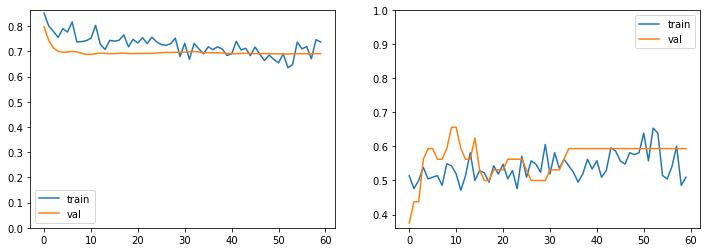

In [32]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 13. Flash Reflection on Skin

84 of 84
70 of 70
(123, 160, 160, 3) float32
(123,) int32
(31, 160, 160, 3) float32
(31,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 59s 585ms/step - loss: 94.3737 - val_loss: 85.6266
Epoch 2/100
100/100 [==============================] - 56s 564ms/step - loss: 80.6040 - val_loss: 92.7885
Epoch 3/100
100/100 [==============================] - 56s 562ms/step - loss: 67.2944 - val_loss: 101.8192
Epoch 4/100
100/100 [==============================] - 56s 563ms/step - loss: 62.6577 - val_loss: 105.8595
Epoch 5/100
100/100 [==============================] - 56s 561ms/step - loss: 56.8029 - val_loss: 102.6945
Epoch 6/100
100/100 [==============================] - 56s 561ms/step - loss: 50.6281 - val_loss: 95.5901
Epoch 7/100
100/100 [==============================] - 56s 562ms/step - loss: 45.9582 - val_loss: 86.8793
Epoch 8/100
100/100 [==============================] - 56s 562ms/step - loss: 42.2597 - val_loss: 67.6377
Epoch 9/100
100/100 [==============================] - 56s 562ms/step - loss: 40.0114 - val_loss: 72.1445
Epoch 10/100
100/100 [=====================

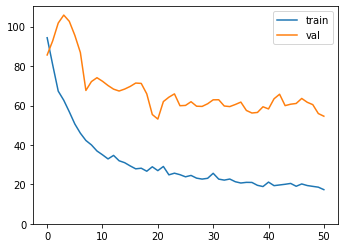

In [33]:
REQ_NAME = 'flash_reflection_on_skin'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
4/4 [==============================] - 3s 650ms/step - loss: 0.6861 - accuracy: 0.6250 - precision: 0.6431 - recall: 0.6012 - f1: 0.6143 - specificity: 0.6436 - negative_predictive_value: 0.6115 - matthews_correlation_coefficient: 0.2495 - equal_error_rate: 0.3820 - val_loss: 0.6263 - val_accuracy: 0.6774 - val_precision: 0.8182 - val_recall: 0.5294 - val_f1: 0.6429 - val_specificity: 0.8571 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.4021 - val_equal_error_rate: 0.3845

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.40206, saving model to ../../models/siamese_networks/flash_reflection_on_skin_2020_06_13-08_10_19.h5
Epoch 2/100
4/4 [==============================] - 1s 174ms/step - loss: 0.7308 - accuracy: 0.6078 - precision: 0.4735 - recall: 0.3797 - f1: 0.4103 - specificity: 0.6955 - negative_predictive_value: 0.6473 - matthews_correlation_coefficient: 0.1001 - equal_error_rate: 0.5296 - val_loss: 0.6264 - v

4/4 [==============================] - 1s 163ms/step - loss: 0.5756 - accuracy: 0.7059 - precision: 0.5754 - recall: 0.4462 - f1: 0.5015 - specificity: 0.8532 - negative_predictive_value: 0.6981 - matthews_correlation_coefficient: 0.3071 - equal_error_rate: 0.4672 - val_loss: 0.6636 - val_accuracy: 0.5806 - val_precision: 0.7500 - val_recall: 0.3529 - val_f1: 0.4800 - val_specificity: 0.8571 - val_negative_predictive_value: 0.5217 - val_matthews_correlation_coefficient: 0.2389 - val_equal_error_rate: 0.2899

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.40206
Epoch 15/100
4/4 [==============================] - 1s 162ms/step - loss: 0.5949 - accuracy: 0.6667 - precision: 0.6815 - recall: 0.6327 - f1: 0.6102 - specificity: 0.7984 - negative_predictive_value: 0.7124 - matthews_correlation_coefficient: 0.4063 - equal_error_rate: 0.4158 - val_loss: 0.6620 - val_accuracy: 0.5806 - val_precision: 0.7500 - val_recall: 0.3529 - val_f1: 0.4800 - val_specificity: 0.8571


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.40206
Epoch 28/100
4/4 [==============================] - 1s 141ms/step - loss: 0.5548 - accuracy: 0.6667 - precision: 0.7910 - recall: 0.6967 - f1: 0.7188 - specificity: 0.7881 - negative_predictive_value: 0.7288 - matthews_correlation_coefficient: 0.5016 - equal_error_rate: 0.3980 - val_loss: 0.6699 - val_accuracy: 0.6129 - val_precision: 0.7778 - val_recall: 0.4118 - val_f1: 0.5385 - val_specificity: 0.8571 - val_negative_predictive_value: 0.5455 - val_matthews_correlation_coefficient: 0.2948 - val_equal_error_rate: 0.2899

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.40206
Epoch 29/100
4/4 [==============================] - 1s 167ms/step - loss: 0.6984 - accuracy: 0.6471 - precision: 0.4889 - recall: 0.4392 - f1: 0.4578 - specificity: 0.7269 - negative_predictive_value: 0.6799 - matthews_correlation_coefficient: 0.1674 - equal_error_rate: 0.4826 - val_loss: 0.6728 - val_accuracy: 0

4/4 [==============================] - 1s 180ms/step - loss: 0.5507 - accuracy: 0.7266 - precision: 0.8105 - recall: 0.6254 - f1: 0.6853 - specificity: 0.8356 - negative_predictive_value: 0.6978 - matthews_correlation_coefficient: 0.4829 - equal_error_rate: 0.2892 - val_loss: 0.6755 - val_accuracy: 0.6129 - val_precision: 0.7778 - val_recall: 0.4118 - val_f1: 0.5385 - val_specificity: 0.8571 - val_negative_predictive_value: 0.5455 - val_matthews_correlation_coefficient: 0.2948 - val_equal_error_rate: 0.2899

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.40206
Epoch 42/100
4/4 [==============================] - 1s 152ms/step - loss: 0.5568 - accuracy: 0.7157 - precision: 0.5631 - recall: 0.4855 - f1: 0.5131 - specificity: 0.8288 - negative_predictive_value: 0.7304 - matthews_correlation_coefficient: 0.3245 - equal_error_rate: 0.3125 - val_loss: 0.6821 - val_accuracy: 0.6129 - val_precision: 0.7778 - val_recall: 0.4118 - val_f1: 0.5385 - val_specificity: 0.8571

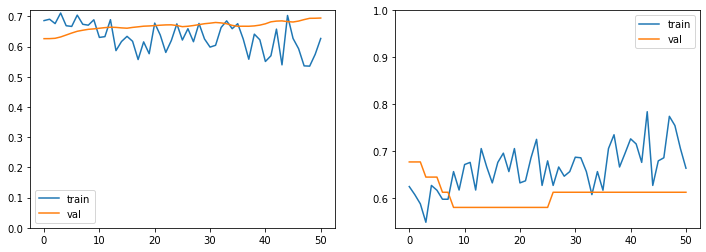

In [34]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 14. Red Eyes 

78 of 78
39 of 39
(93, 160, 160, 3) float32
(93,) int32
(24, 160, 160, 3) float32
(24,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 56s 562ms/step - loss: 96.1010 - val_loss: 91.2017
Epoch 2/100
100/100 [==============================] - 54s 540ms/step - loss: 85.2569 - val_loss: 65.9581
Epoch 3/100
100/100 [==============================] - 54s 540ms/step - loss: 76.5075 - val_loss: 56.4639
Epoch 4/100
100/100 [==============================] - 54s 539ms/step - loss: 69.3358 - val_loss: 55.5582
Epoch 5/100
100/100 [==============================] - 54s 539ms/step - loss: 60.1246 - val_loss: 52.3518
Epoch 6/100
100/100 [==============================] - 54s 540ms/step - loss: 52.5562 - val_loss: 59.2637
Epoch 7/100
100/100 [==============================] - 54s 540ms/step - loss: 46.6688 - val_loss: 57.1108
Epoch 8/100
100/100 [==============================] - 54s 540ms/step - loss: 43.1429 - val_loss: 59.2566
Epoch 9/100
100/100 [==============================] - 54s 540ms/step - loss: 37.6553 - val_loss: 56.1861
Epoch 10/100
100/100 [========================

Epoch 78/100
100/100 [==============================] - 54s 539ms/step - loss: 7.7693 - val_loss: 34.7738
Epoch 79/100
100/100 [==============================] - 54s 539ms/step - loss: 7.5569 - val_loss: 38.3479
Epoch 80/100
100/100 [==============================] - 55s 546ms/step - loss: 7.1310 - val_loss: 38.4792
Epoch 81/100
100/100 [==============================] - 54s 540ms/step - loss: 7.4876 - val_loss: 39.4838
Epoch 82/100
100/100 [==============================] - 54s 539ms/step - loss: 6.4962 - val_loss: 26.9349
Epoch 83/100
100/100 [==============================] - 54s 540ms/step - loss: 7.3010 - val_loss: 33.7188
Epoch 84/100
100/100 [==============================] - 54s 539ms/step - loss: 6.9935 - val_loss: 33.2634
Epoch 85/100
100/100 [==============================] - 54s 540ms/step - loss: 7.1616 - val_loss: 37.7689
Epoch 86/100
100/100 [==============================] - 54s 540ms/step - loss: 7.3719 - val_loss: 33.8832
Epoch 87/100
100/100 [========================

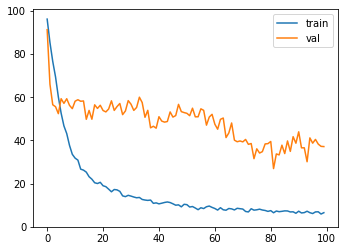

In [35]:
REQ_NAME = 'red_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 3s 949ms/step - loss: 1.2984 - accuracy: 0.3229 - precision: 0.3806 - recall: 0.5885 - f1: 0.4570 - specificity: 0.0629 - negative_predictive_value: 0.1369 - matthews_correlation_coefficient: -0.4100 - equal_error_rate: 0.7169 - val_loss: 0.7736 - val_accuracy: 0.5417 - val_precision: 0.5263 - val_recall: 0.8333 - val_f1: 0.6452 - val_specificity: 0.2500 - val_negative_predictive_value: 0.6000 - val_matthews_correlation_coefficient: 0.1026 - val_equal_error_rate: 0.5417

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.10260, saving model to ../../models/siamese_networks/red_eyes_2020_06_13-09_42_38.h5
Epoch 2/100
3/3 [==============================] - 1s 200ms/step - loss: 1.4252 - accuracy: 0.2391 - precision: 0.2927 - recall: 0.4507 - f1: 0.3529 - specificity: 0.0627 - negative_predictive_value: 0.1023 - matthews_correlation_coefficient: -0.5418 - equal_error_rate: 0.7428 - val_loss: 0.7656 - val_accuracy: 0

3/3 [==============================] - 1s 193ms/step - loss: 0.7592 - accuracy: 0.5761 - precision: 0.5233 - recall: 0.5890 - f1: 0.5527 - specificity: 0.5486 - negative_predictive_value: 0.6268 - matthews_correlation_coefficient: 0.1437 - equal_error_rate: 0.3962 - val_loss: 0.6996 - val_accuracy: 0.4583 - val_precision: 0.4783 - val_recall: 0.9167 - val_f1: 0.6286 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.2085 - val_equal_error_rate: 0.5417

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.22361
Epoch 15/100
3/3 [==============================] - 1s 193ms/step - loss: 0.7329 - accuracy: 0.5978 - precision: 0.6708 - recall: 0.5607 - f1: 0.5912 - specificity: 0.6498 - negative_predictive_value: 0.5651 - matthews_correlation_coefficient: 0.2224 - equal_error_rate: 0.4240 - val_loss: 0.6984 - val_accuracy: 0.4583 - val_precision: 0.4783 - val_recall: 0.9167 - val_f1: 0.6286 - val_specificit

3/3 [==============================] - 1s 216ms/step - loss: 0.5866 - accuracy: 0.6848 - precision: 0.7175 - recall: 0.7043 - f1: 0.7049 - specificity: 0.6666 - negative_predictive_value: 0.6490 - matthews_correlation_coefficient: 0.3686 - equal_error_rate: 0.2699 - val_loss: 0.7043 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_f1: 0.6667 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: 0.0000e+00 - val_equal_error_rate: 0.1667

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.22361
Epoch 28/100
3/3 [==============================] - 1s 176ms/step - loss: 0.5609 - accuracy: 0.7500 - precision: 0.7886 - recall: 0.7103 - f1: 0.7465 - specificity: 0.7934 - negative_predictive_value: 0.7037 - matthews_correlation_coefficient: 0.4980 - equal_error_rate: 0.2379 - val_loss: 0.7064 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_f1: 0.6667 - val_specifi

3/3 [==============================] - 1s 186ms/step - loss: 0.4880 - accuracy: 0.7717 - precision: 0.8429 - recall: 0.7127 - f1: 0.7620 - specificity: 0.8234 - negative_predictive_value: 0.7274 - matthews_correlation_coefficient: 0.5521 - equal_error_rate: 0.2252 - val_loss: 0.7283 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_f1: 0.6667 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: 0.0000e+00 - val_equal_error_rate: 0.3750

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.22361
Epoch 41/100
3/3 [==============================] - 1s 218ms/step - loss: 0.3964 - accuracy: 0.8542 - precision: 0.9364 - recall: 0.7355 - f1: 0.8238 - specificity: 0.9639 - negative_predictive_value: 0.7926 - matthews_correlation_coefficient: 0.7135 - equal_error_rate: 0.1548 - val_loss: 0.7313 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_f1: 0.6667 - val_specifi

3/3 [==============================] - 1s 196ms/step - loss: 0.3663 - accuracy: 0.8021 - precision: 0.8041 - recall: 0.7850 - f1: 0.7898 - specificity: 0.8299 - negative_predictive_value: 0.7960 - matthews_correlation_coefficient: 0.6074 - equal_error_rate: 0.1770 - val_loss: 0.7752 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_f1: 0.6667 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: 0.0000e+00 - val_equal_error_rate: 0.3750

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.22361
Epoch 54/100
3/3 [==============================] - 1s 208ms/step - loss: 0.3651 - accuracy: 0.8804 - precision: 0.8653 - recall: 0.8873 - f1: 0.8693 - specificity: 0.8847 - negative_predictive_value: 0.8971 - matthews_correlation_coefficient: 0.7671 - equal_error_rate: 0.1229 - val_loss: 0.7772 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_f1: 0.6667 - val_specifi

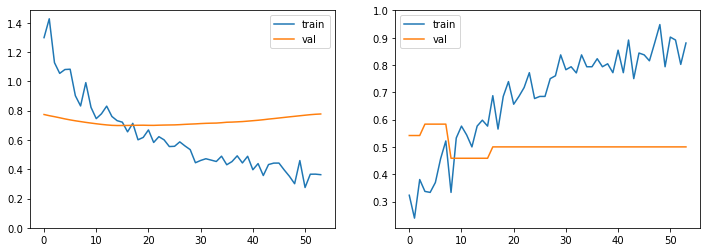

In [36]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 15. Shadows Behind Head 

99 of 99
94 of 94
(154, 160, 160, 3) float32
(154,) int32
(39, 160, 160, 3) float32
(39,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 66s 663ms/step - loss: 84.2172 - val_loss: 85.1616
Epoch 2/100
100/100 [==============================] - 58s 577ms/step - loss: 73.9196 - val_loss: 80.6905
Epoch 3/100
100/100 [==============================] - 58s 577ms/step - loss: 66.9913 - val_loss: 72.6486
Epoch 4/100
100/100 [==============================] - 58s 577ms/step - loss: 55.7459 - val_loss: 66.4875
Epoch 5/100
100/100 [==============================] - 58s 577ms/step - loss: 52.0979 - val_loss: 63.3118
Epoch 6/100
100/100 [==============================] - 58s 578ms/step - loss: 43.6857 - val_loss: 65.5812
Epoch 7/100
100/100 [==============================] - 58s 577ms/step - loss: 40.5285 - val_loss: 63.9484
Epoch 8/100
100/100 [==============================] - 58s 577ms/step - loss: 36.2221 - val_loss: 63.5885
Epoch 9/100
100/100 [==============================] - 58s 577ms/step - loss: 33.3195 - val_loss: 71.5387
Epoch 10/100
100/100 [========================

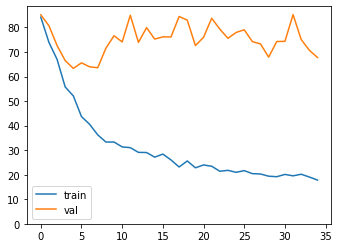

In [37]:
REQ_NAME = 'shadows_behind_head'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
4/4 [==============================] - 3s 764ms/step - loss: 0.6509 - accuracy: 0.6328 - precision: 0.6217 - recall: 0.7566 - f1: 0.6745 - specificity: 0.5179 - negative_predictive_value: 0.6600 - matthews_correlation_coefficient: 0.2780 - equal_error_rate: 0.3500 - val_loss: 0.6250 - val_accuracy: 0.6875 - val_precision: 0.7273 - val_recall: 0.5333 - val_f1: 0.6154 - val_specificity: 0.8235 - val_negative_predictive_value: 0.6667 - val_matthews_correlation_coefficient: 0.3749 - val_equal_error_rate: 0.2510

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.37494, saving model to ../../models/siamese_networks/shadows_behind_head_2020_06_13-10_19_02.h5
Epoch 2/100
4/4 [==============================] - 1s 160ms/step - loss: 0.6791 - accuracy: 0.5952 - precision: 0.5621 - recall: 0.7283 - f1: 0.6258 - specificity: 0.4799 - negative_predictive_value: 0.6689 - matthews_correlation_coefficient: 0.2189 - equal_error_rate: 0.3705 - val_loss: 0.6165 - val_ac

4/4 [==============================] - 1s 217ms/step - loss: 0.5744 - accuracy: 0.7619 - precision: 0.7452 - recall: 0.7878 - f1: 0.7555 - specificity: 0.7507 - negative_predictive_value: 0.7888 - matthews_correlation_coefficient: 0.5361 - equal_error_rate: 0.2019 - val_loss: 0.5779 - val_accuracy: 0.7500 - val_precision: 0.8182 - val_recall: 0.6000 - val_f1: 0.6923 - val_specificity: 0.8824 - val_negative_predictive_value: 0.7143 - val_matthews_correlation_coefficient: 0.5068 - val_equal_error_rate: 0.3137

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.50679
Epoch 15/100
4/4 [==============================] - 1s 213ms/step - loss: 0.5618 - accuracy: 0.7302 - precision: 0.7798 - recall: 0.7072 - f1: 0.7332 - specificity: 0.7782 - negative_predictive_value: 0.7004 - matthews_correlation_coefficient: 0.4828 - equal_error_rate: 0.2854 - val_loss: 0.5771 - val_accuracy: 0.7500 - val_precision: 0.8182 - val_recall: 0.6000 - val_f1: 0.6923 - val_specificity: 0.8824


Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.50679
Epoch 28/100
4/4 [==============================] - 1s 207ms/step - loss: 0.5726 - accuracy: 0.7381 - precision: 0.7912 - recall: 0.6235 - f1: 0.6966 - specificity: 0.8350 - negative_predictive_value: 0.6857 - matthews_correlation_coefficient: 0.4675 - equal_error_rate: 0.2996 - val_loss: 0.5824 - val_accuracy: 0.7500 - val_precision: 0.8182 - val_recall: 0.6000 - val_f1: 0.6923 - val_specificity: 0.8824 - val_negative_predictive_value: 0.7143 - val_matthews_correlation_coefficient: 0.5068 - val_equal_error_rate: 0.3765

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.50679
Epoch 29/100
4/4 [==============================] - 1s 211ms/step - loss: 0.5408 - accuracy: 0.7778 - precision: 0.7581 - recall: 0.7965 - f1: 0.7720 - specificity: 0.7614 - negative_predictive_value: 0.7990 - matthews_correlation_coefficient: 0.5574 - equal_error_rate: 0.2236 - val_loss: 0.5828 - val_accuracy: 0

4/4 [==============================] - 1s 214ms/step - loss: 0.4399 - accuracy: 0.8594 - precision: 0.8736 - recall: 0.8431 - f1: 0.8540 - specificity: 0.8719 - negative_predictive_value: 0.8429 - matthews_correlation_coefficient: 0.7156 - equal_error_rate: 0.1535 - val_loss: 0.5915 - val_accuracy: 0.7500 - val_precision: 0.8182 - val_recall: 0.6000 - val_f1: 0.6923 - val_specificity: 0.8824 - val_negative_predictive_value: 0.7143 - val_matthews_correlation_coefficient: 0.5068 - val_equal_error_rate: 0.3765

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.50679
Epoch 42/100
4/4 [==============================] - 1s 222ms/step - loss: 0.4885 - accuracy: 0.8016 - precision: 0.8152 - recall: 0.7627 - f1: 0.7845 - specificity: 0.8455 - negative_predictive_value: 0.7839 - matthews_correlation_coefficient: 0.6036 - equal_error_rate: 0.1827 - val_loss: 0.5936 - val_accuracy: 0.7500 - val_precision: 0.8182 - val_recall: 0.6000 - val_f1: 0.6923 - val_specificity: 0.8824


Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.50679
Epoch 55/100
4/4 [==============================] - 1s 222ms/step - loss: 0.4800 - accuracy: 0.7857 - precision: 0.7905 - recall: 0.8019 - f1: 0.7935 - specificity: 0.7676 - negative_predictive_value: 0.7725 - matthews_correlation_coefficient: 0.5662 - equal_error_rate: 0.2147 - val_loss: 0.6069 - val_accuracy: 0.7500 - val_precision: 0.8182 - val_recall: 0.6000 - val_f1: 0.6923 - val_specificity: 0.8824 - val_negative_predictive_value: 0.7143 - val_matthews_correlation_coefficient: 0.5068 - val_equal_error_rate: 0.3765

Epoch 00055: val_matthews_correlation_coefficient did not improve from 0.50679
Epoch 56/100
4/4 [==============================] - 1s 204ms/step - loss: 0.4820 - accuracy: 0.7812 - precision: 0.8503 - recall: 0.7003 - f1: 0.7628 - specificity: 0.8802 - negative_predictive_value: 0.7288 - matthews_correlation_coefficient: 0.5798 - equal_error_rate: 0.2098 - val_loss: 0.6084 - val_accuracy: 0

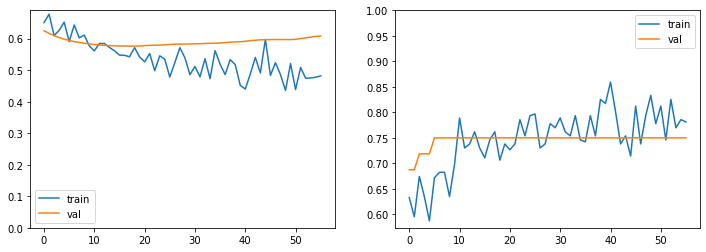

In [38]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 16. Shadows Across Face

158 of 158
141 of 141
(238, 160, 160, 3) float32
(238,) int32
(61, 160, 160, 3) float32
(61,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 68s 677ms/step - loss: 93.0832 - val_loss: 70.2187
Epoch 2/100
100/100 [==============================] - 68s 679ms/step - loss: 76.2599 - val_loss: 58.3948
Epoch 3/100
100/100 [==============================] - 68s 683ms/step - loss: 57.3312 - val_loss: 62.8282
Epoch 4/100
100/100 [==============================] - 68s 676ms/step - loss: 37.7293 - val_loss: 75.8961
Epoch 5/100
100/100 [==============================] - 68s 678ms/step - loss: 29.8624 - val_loss: 78.0897
Epoch 6/100
100/100 [==============================] - 68s 682ms/step - loss: 22.7953 - val_loss: 74.5757
Epoch 7/100
100/100 [==============================] - 68s 680ms/step - loss: 20.9123 - val_loss: 77.3614
Epoch 8/100
100/100 [==============================] - 68s 678ms/step - loss: 17.9279 - val_loss: 76.1197
Epoch 9/100
100/100 [==============================] - 68s 682ms/step - loss: 17.7496 - val_loss: 76.7077
Epoch 10/100
100/100 [========================

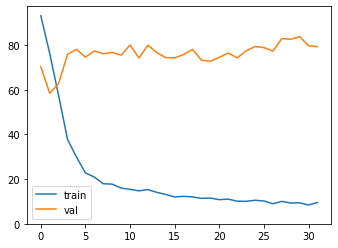

In [39]:
REQ_NAME = 'shadows_across_face'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
7/7 [==============================] - 4s 559ms/step - loss: 0.8317 - accuracy: 0.4196 - precision: 0.4461 - recall: 0.6811 - f1: 0.5348 - specificity: 0.1483 - negative_predictive_value: 0.2893 - matthews_correlation_coefficient: -0.2112 - equal_error_rate: 0.5452 - val_loss: 0.8130 - val_accuracy: 0.4688 - val_precision: 0.4847 - val_recall: 0.8452 - val_f1: 0.6124 - val_specificity: 0.0992 - val_negative_predictive_value: 0.3667 - val_matthews_correlation_coefficient: -0.0906 - val_equal_error_rate: 0.4861

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.09056, saving model to ../../models/siamese_networks/shadows_across_face_2020_06_13-10_58_25.h5
Epoch 2/100
7/7 [==============================] - 1s 173ms/step - loss: 0.7821 - accuracy: 0.4864 - precision: 0.4738 - recall: 0.6716 - f1: 0.5523 - specificity: 0.3149 - negative_predictive_value: 0.5052 - matthews_correlation_coefficient: -0.0170 - equal_error_rate: 0.4567 - val_loss: 0.7354 - va

7/7 [==============================] - 1s 206ms/step - loss: 0.6366 - accuracy: 0.6773 - precision: 0.6773 - recall: 0.6600 - f1: 0.6646 - specificity: 0.6937 - negative_predictive_value: 0.6690 - matthews_correlation_coefficient: 0.3498 - equal_error_rate: 0.3145 - val_loss: 0.4750 - val_accuracy: 0.7656 - val_precision: 0.9231 - val_recall: 0.5913 - val_f1: 0.7185 - val_specificity: 0.9286 - val_negative_predictive_value: 0.6908 - val_matthews_correlation_coefficient: 0.5638 - val_equal_error_rate: 0.2500

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.56381
Epoch 14/100
7/7 [==============================] - 1s 200ms/step - loss: 0.6446 - accuracy: 0.6545 - precision: 0.6335 - recall: 0.6427 - f1: 0.6341 - specificity: 0.6412 - negative_predictive_value: 0.6578 - matthews_correlation_coefficient: 0.2875 - equal_error_rate: 0.3743 - val_loss: 0.4672 - val_accuracy: 0.7656 - val_precision: 0.9231 - val_recall: 0.5913 - val_f1: 0.7185 - val_specificity: 0.9286

7/7 [==============================] - 1s 206ms/step - loss: 0.5673 - accuracy: 0.7636 - precision: 0.7905 - recall: 0.6917 - f1: 0.7336 - specificity: 0.8317 - negative_predictive_value: 0.7486 - matthews_correlation_coefficient: 0.5309 - equal_error_rate: 0.2609 - val_loss: 0.4364 - val_accuracy: 0.7969 - val_precision: 0.9286 - val_recall: 0.6548 - val_f1: 0.7663 - val_specificity: 0.9286 - val_negative_predictive_value: 0.7246 - val_matthews_correlation_coefficient: 0.6166 - val_equal_error_rate: 0.2817

Epoch 00026: val_matthews_correlation_coefficient did not improve from 0.61655
Epoch 27/100
7/7 [==============================] - 1s 206ms/step - loss: 0.6022 - accuracy: 0.6818 - precision: 0.7166 - recall: 0.6292 - f1: 0.6633 - specificity: 0.7400 - negative_predictive_value: 0.6560 - matthews_correlation_coefficient: 0.3706 - equal_error_rate: 0.3404 - val_loss: 0.4355 - val_accuracy: 0.7969 - val_precision: 0.9286 - val_recall: 0.6548 - val_f1: 0.7663 - val_specificity: 0.9286


Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.61655
Epoch 40/100
7/7 [==============================] - 1s 210ms/step - loss: 0.5854 - accuracy: 0.6818 - precision: 0.6722 - recall: 0.6679 - f1: 0.6664 - specificity: 0.6994 - negative_predictive_value: 0.6899 - matthews_correlation_coefficient: 0.3646 - equal_error_rate: 0.3070 - val_loss: 0.4311 - val_accuracy: 0.7969 - val_precision: 0.9286 - val_recall: 0.6548 - val_f1: 0.7663 - val_specificity: 0.9286 - val_negative_predictive_value: 0.7246 - val_matthews_correlation_coefficient: 0.6166 - val_equal_error_rate: 0.2817

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.61655
Epoch 41/100
7/7 [==============================] - 1s 212ms/step - loss: 0.5742 - accuracy: 0.7188 - precision: 0.7629 - recall: 0.6397 - f1: 0.6850 - specificity: 0.8049 - negative_predictive_value: 0.6967 - matthews_correlation_coefficient: 0.4517 - equal_error_rate: 0.2914 - val_loss: 0.4312 - val_accuracy: 0

7/7 [==============================] - 1s 206ms/step - loss: 0.5643 - accuracy: 0.7136 - precision: 0.7377 - recall: 0.6374 - f1: 0.6795 - specificity: 0.7852 - negative_predictive_value: 0.6894 - matthews_correlation_coefficient: 0.4245 - equal_error_rate: 0.2989 - val_loss: 0.4289 - val_accuracy: 0.7812 - val_precision: 0.9286 - val_recall: 0.6190 - val_f1: 0.7386 - val_specificity: 0.9286 - val_negative_predictive_value: 0.7083 - val_matthews_correlation_coefficient: 0.5892 - val_equal_error_rate: 0.2500

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.61655
Epoch 54/100
7/7 [==============================] - 2s 217ms/step - loss: 0.5577 - accuracy: 0.7455 - precision: 0.7564 - recall: 0.6802 - f1: 0.7107 - specificity: 0.8028 - negative_predictive_value: 0.7298 - matthews_correlation_coefficient: 0.4842 - equal_error_rate: 0.2771 - val_loss: 0.4288 - val_accuracy: 0.7812 - val_precision: 0.9286 - val_recall: 0.6190 - val_f1: 0.7386 - val_specificity: 0.9286


Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.61655
Epoch 67/100
7/7 [==============================] - 1s 213ms/step - loss: 0.5678 - accuracy: 0.7455 - precision: 0.7827 - recall: 0.6913 - f1: 0.7286 - specificity: 0.8020 - negative_predictive_value: 0.7171 - matthews_correlation_coefficient: 0.4963 - equal_error_rate: 0.2621 - val_loss: 0.4296 - val_accuracy: 0.7812 - val_precision: 0.9286 - val_recall: 0.6190 - val_f1: 0.7386 - val_specificity: 0.9286 - val_negative_predictive_value: 0.7083 - val_matthews_correlation_coefficient: 0.5892 - val_equal_error_rate: 0.2183

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.61655
Epoch 68/100
7/7 [==============================] - 1s 192ms/step - loss: 0.5697 - accuracy: 0.7318 - precision: 0.7860 - recall: 0.6292 - f1: 0.6904 - specificity: 0.8365 - negative_predictive_value: 0.6976 - matthews_correlation_coefficient: 0.4738 - equal_error_rate: 0.2941 - val_loss: 0.4285 - val_accuracy: 0

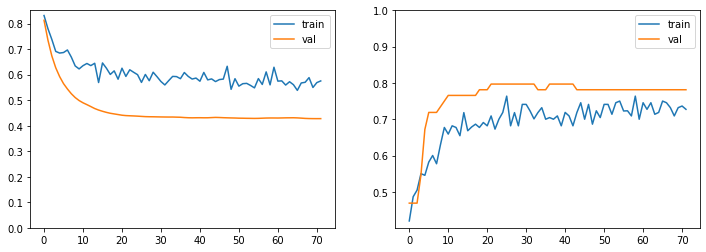

In [40]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 17. Dark Tinted Lenses

315 of 315
136 of 136
(360, 160, 160, 3) float32
(360,) int32
(91, 160, 160, 3) float32
(91,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 115s 1s/step - loss: 96.1880 - val_loss: 85.9066
Epoch 2/100
100/100 [==============================] - 118s 1s/step - loss: 91.1131 - val_loss: 82.6601
Epoch 3/100
100/100 [==============================] - 119s 1s/step - loss: 85.5489 - val_loss: 87.1081
Epoch 4/100
100/100 [==============================] - 117s 1s/step - loss: 84.3557 - val_loss: 96.2858
Epoch 5/100
100/100 [==============================] - 118s 1s/step - loss: 81.8060 - val_loss: 98.0663
Epoch 6/100
100/100 [==============================] - 119s 1s/step - loss: 78.8495 - val_loss: 90.4178
Epoch 7/100
100/100 [==============================] - 117s 1s/step - loss: 75.7363 - val_loss: 93.5036
Epoch 8/100
100/100 [==============================] - 118s 1s/step - loss: 74.4222 - val_loss: 100.8858
Epoch 9/100
100/100 [==============================] - 119s 1s/step - loss: 72.6977 - val_loss: 100.2669
Epoch 10/100
100/100 [==============================] - 117s 1

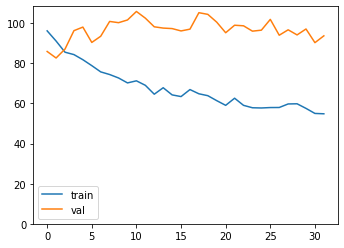

In [41]:
REQ_NAME = 'dark_tinted_lenses'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.9, 1.1),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
15/15 [==============================] - 5s 345ms/step - loss: 0.7463 - accuracy: 0.4500 - precision: 0.4626 - recall: 0.5943 - f1: 0.5134 - specificity: 0.2941 - negative_predictive_value: 0.4093 - matthews_correlation_coefficient: -0.1192 - equal_error_rate: 0.5038 - val_loss: 0.6382 - val_accuracy: 0.6250 - val_precision: 0.6607 - val_recall: 0.5797 - val_f1: 0.6161 - val_specificity: 0.6722 - val_negative_predictive_value: 0.5957 - val_matthews_correlation_coefficient: 0.2541 - val_equal_error_rate: 0.3434

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25415, saving model to ../../models/siamese_networks/dark_tinted_lenses_2020_06_13-12_05_33.h5
Epoch 2/100
15/15 [==============================] - 2s 151ms/step - loss: 0.7210 - accuracy: 0.5042 - precision: 0.5043 - recall: 0.5574 - f1: 0.5203 - specificity: 0.4506 - negative_predictive_value: 0.5023 - matthews_correlation_coefficient: 0.0072 - equal_error_rate: 0.5103 - val_loss: 0.6396 - va


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.29779
Epoch 14/100
15/15 [==============================] - 6s 397ms/step - loss: 0.7085 - accuracy: 0.5424 - precision: 0.5436 - recall: 0.5369 - f1: 0.5315 - specificity: 0.5468 - negative_predictive_value: 0.5357 - matthews_correlation_coefficient: 0.0814 - equal_error_rate: 0.4530 - val_loss: 0.6718 - val_accuracy: 0.6042 - val_precision: 0.6815 - val_recall: 0.4412 - val_f1: 0.5309 - val_specificity: 0.7819 - val_negative_predictive_value: 0.5660 - val_matthews_correlation_coefficient: 0.2348 - val_equal_error_rate: 0.3643

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.29779
Epoch 15/100
15/15 [==============================] - 6s 396ms/step - loss: 0.6776 - accuracy: 0.5530 - precision: 0.5564 - recall: 0.6207 - f1: 0.5728 - specificity: 0.5178 - negative_predictive_value: 0.5788 - matthews_correlation_coefficient: 0.1367 - equal_error_rate: 0.4042 - val_loss: 0.6747 - val_accurac

15/15 [==============================] - 6s 398ms/step - loss: 0.6814 - accuracy: 0.5614 - precision: 0.5672 - recall: 0.5279 - f1: 0.5377 - specificity: 0.5919 - negative_predictive_value: 0.5507 - matthews_correlation_coefficient: 0.1187 - equal_error_rate: 0.4438 - val_loss: 0.6962 - val_accuracy: 0.5312 - val_precision: 0.5458 - val_recall: 0.5821 - val_f1: 0.5625 - val_specificity: 0.4764 - val_negative_predictive_value: 0.5140 - val_matthews_correlation_coefficient: 0.0591 - val_equal_error_rate: 0.4884

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.29779
Epoch 28/100
15/15 [==============================] - 6s 400ms/step - loss: 0.6739 - accuracy: 0.5742 - precision: 0.5652 - recall: 0.6170 - f1: 0.5819 - specificity: 0.5303 - negative_predictive_value: 0.5810 - matthews_correlation_coefficient: 0.1467 - equal_error_rate: 0.4290 - val_loss: 0.6978 - val_accuracy: 0.5000 - val_precision: 0.5185 - val_recall: 0.6017 - val_f1: 0.5556 - val_specificity: 0.


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.29779
Epoch 41/100
15/15 [==============================] - 6s 393ms/step - loss: 0.6802 - accuracy: 0.5508 - precision: 0.5632 - recall: 0.4927 - f1: 0.5205 - specificity: 0.6079 - negative_predictive_value: 0.5336 - matthews_correlation_coefficient: 0.0985 - equal_error_rate: 0.4442 - val_loss: 0.7102 - val_accuracy: 0.4167 - val_precision: 0.4463 - val_recall: 0.4816 - val_f1: 0.4630 - val_specificity: 0.3458 - val_negative_predictive_value: 0.3769 - val_matthews_correlation_coefficient: -0.1746 - val_equal_error_rate: 0.4989

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.29779
Epoch 42/100
15/15 [==============================] - 6s 401ms/step - loss: 0.6749 - accuracy: 0.5381 - precision: 0.5508 - recall: 0.5146 - f1: 0.5194 - specificity: 0.5668 - negative_predictive_value: 0.5332 - matthews_correlation_coefficient: 0.0826 - equal_error_rate: 0.4553 - val_loss: 0.7093 - val_accura

15/15 [==============================] - 6s 395ms/step - loss: 0.6776 - accuracy: 0.5614 - precision: 0.5535 - recall: 0.5392 - f1: 0.5377 - specificity: 0.5855 - negative_predictive_value: 0.5707 - matthews_correlation_coefficient: 0.1245 - equal_error_rate: 0.4355 - val_loss: 0.7123 - val_accuracy: 0.4271 - val_precision: 0.4579 - val_recall: 0.4816 - val_f1: 0.4661 - val_specificity: 0.3722 - val_negative_predictive_value: 0.3892 - val_matthews_correlation_coefficient: -0.1495 - val_equal_error_rate: 0.5198

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.29779
Epoch 55/100
15/15 [==============================] - 6s 402ms/step - loss: 0.6705 - accuracy: 0.5636 - precision: 0.5815 - recall: 0.5314 - f1: 0.5467 - specificity: 0.6021 - negative_predictive_value: 0.5482 - matthews_correlation_coefficient: 0.1315 - equal_error_rate: 0.4320 - val_loss: 0.7152 - val_accuracy: 0.4062 - val_precision: 0.4455 - val_recall: 0.5025 - val_f1: 0.4672 - val_specificity: 0

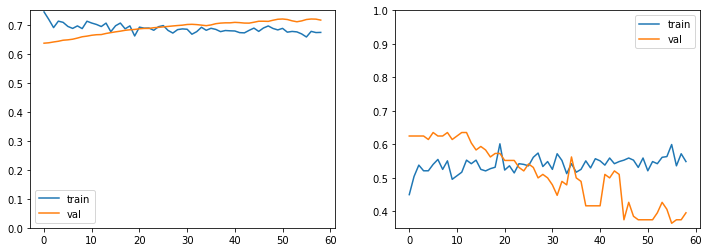

In [42]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 18. Flash Reflection on Lenses

437 of 437
363 of 363
(639, 160, 160, 3) float32
(639,) int32
(161, 160, 160, 3) float32
(161,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 73s 726ms/step - loss: 87.7378 - val_loss: 101.7521
Epoch 2/100
100/100 [==============================] - 71s 712ms/step - loss: 71.1710 - val_loss: 100.8352
Epoch 3/100
100/100 [==============================] - 72s 718ms/step - loss: 63.0726 - val_loss: 100.4951
Epoch 4/100
100/100 [==============================] - 72s 723ms/step - loss: 62.5408 - val_loss: 103.7159
Epoch 5/100
100/100 [==============================] - 73s 731ms/step - loss: 60.2053 - val_loss: 107.3969
Epoch 6/100
100/100 [==============================] - 73s 734ms/step - loss: 54.9563 - val_loss: 103.6326
Epoch 7/100
100/100 [==============================] - 74s 737ms/step - loss: 58.0212 - val_loss: 107.0897
Epoch 8/100
100/100 [==============================] - 74s 743ms/step - loss: 56.2699 - val_loss: 109.7182
Epoch 9/100
100/100 [==============================] - 75s 749ms/step - loss: 53.4656 - val_loss: 111.4597
Epoch 10/100
100/100 [===============

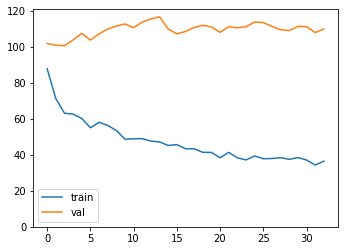

In [43]:
REQ_NAME = 'flash_reflection_on_lenses'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
21/21 [==============================] - 7s 311ms/step - loss: 0.7496 - accuracy: 0.5565 - precision: 0.5461 - recall: 0.7348 - f1: 0.6146 - specificity: 0.3941 - negative_predictive_value: 0.6087 - matthews_correlation_coefficient: 0.1393 - equal_error_rate: 0.4330 - val_loss: 0.6830 - val_accuracy: 0.5562 - val_precision: 0.5040 - val_recall: 0.3648 - val_f1: 0.4215 - val_specificity: 0.6826 - val_negative_predictive_value: 0.5422 - val_matthews_correlation_coefficient: 0.0468 - val_equal_error_rate: 0.4577

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.04681, saving model to ../../models/siamese_networks/flash_reflection_on_lenses_2020_06_13-12_54_32.h5
Epoch 2/100
21/21 [==============================] - 3s 151ms/step - loss: 0.6926 - accuracy: 0.5856 - precision: 0.5904 - recall: 0.6321 - f1: 0.6018 - specificity: 0.5522 - negative_predictive_value: 0.5915 - matthews_correlation_coefficient: 0.1830 - equal_error_rate: 0.3869 - val_loss: 0.69


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.17704
Epoch 14/100
21/21 [==============================] - 5s 239ms/step - loss: 0.6739 - accuracy: 0.5631 - precision: 0.5645 - recall: 0.5407 - f1: 0.5428 - specificity: 0.5931 - negative_predictive_value: 0.5719 - matthews_correlation_coefficient: 0.1351 - equal_error_rate: 0.4249 - val_loss: 0.6495 - val_accuracy: 0.5813 - val_precision: 0.7200 - val_recall: 0.1776 - val_f1: 0.2788 - val_specificity: 0.9459 - val_negative_predictive_value: 0.5525 - val_matthews_correlation_coefficient: 0.1770 - val_equal_error_rate: 0.4651

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.17704
Epoch 15/100
21/21 [==============================] - 5s 239ms/step - loss: 0.6684 - accuracy: 0.5916 - precision: 0.5936 - recall: 0.5655 - f1: 0.5700 - specificity: 0.6169 - negative_predictive_value: 0.5884 - matthews_correlation_coefficient: 0.1821 - equal_error_rate: 0.4136 - val_loss: 0.6471 - val_accurac

21/21 [==============================] - 5s 235ms/step - loss: 0.6750 - accuracy: 0.5826 - precision: 0.6035 - recall: 0.5055 - f1: 0.5451 - specificity: 0.6648 - negative_predictive_value: 0.5659 - matthews_correlation_coefficient: 0.1698 - equal_error_rate: 0.4289 - val_loss: 0.6285 - val_accuracy: 0.5813 - val_precision: 0.7200 - val_recall: 0.1776 - val_f1: 0.2788 - val_specificity: 0.9459 - val_negative_predictive_value: 0.5525 - val_matthews_correlation_coefficient: 0.1770 - val_equal_error_rate: 0.4345

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.17704
Epoch 28/100
21/21 [==============================] - 5s 237ms/step - loss: 0.6606 - accuracy: 0.5991 - precision: 0.6101 - recall: 0.5598 - f1: 0.5755 - specificity: 0.6342 - negative_predictive_value: 0.5888 - matthews_correlation_coefficient: 0.1964 - equal_error_rate: 0.3980 - val_loss: 0.6301 - val_accuracy: 0.5813 - val_precision: 0.7200 - val_recall: 0.1776 - val_f1: 0.2788 - val_specificity: 0.

21/21 [==============================] - 5s 240ms/step - loss: 0.6457 - accuracy: 0.6156 - precision: 0.6343 - recall: 0.5236 - f1: 0.5672 - specificity: 0.7107 - negative_predictive_value: 0.6038 - matthews_correlation_coefficient: 0.2362 - equal_error_rate: 0.3877 - val_loss: 0.6321 - val_accuracy: 0.5875 - val_precision: 0.7400 - val_recall: 0.1930 - val_f1: 0.2984 - val_specificity: 0.9459 - val_negative_predictive_value: 0.5570 - val_matthews_correlation_coefficient: 0.1966 - val_equal_error_rate: 0.4998

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.19657
Epoch 41/100
21/21 [==============================] - 5s 237ms/step - loss: 0.6666 - accuracy: 0.5991 - precision: 0.6262 - recall: 0.5145 - f1: 0.5554 - specificity: 0.6891 - negative_predictive_value: 0.5829 - matthews_correlation_coefficient: 0.2062 - equal_error_rate: 0.4200 - val_loss: 0.6337 - val_accuracy: 0.5875 - val_precision: 0.7400 - val_recall: 0.1930 - val_f1: 0.2984 - val_specificity: 0.

21/21 [==============================] - 5s 238ms/step - loss: 0.6630 - accuracy: 0.6066 - precision: 0.6440 - recall: 0.4987 - f1: 0.5524 - specificity: 0.7231 - negative_predictive_value: 0.5900 - matthews_correlation_coefficient: 0.2276 - equal_error_rate: 0.3982 - val_loss: 0.6254 - val_accuracy: 0.5875 - val_precision: 0.6976 - val_recall: 0.2308 - val_f1: 0.3340 - val_specificity: 0.9163 - val_negative_predictive_value: 0.5620 - val_matthews_correlation_coefficient: 0.1883 - val_equal_error_rate: 0.4507

Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.21204
Epoch 54/100
21/21 [==============================] - 5s 235ms/step - loss: 0.6450 - accuracy: 0.6276 - precision: 0.6522 - recall: 0.5521 - f1: 0.5879 - specificity: 0.7106 - negative_predictive_value: 0.6131 - matthews_correlation_coefficient: 0.2638 - equal_error_rate: 0.3871 - val_loss: 0.6274 - val_accuracy: 0.5875 - val_precision: 0.6976 - val_recall: 0.2308 - val_f1: 0.3340 - val_specificity: 0.


Epoch 00066: val_matthews_correlation_coefficient did not improve from 0.21204
Epoch 67/100
21/21 [==============================] - 5s 241ms/step - loss: 0.6507 - accuracy: 0.6071 - precision: 0.6351 - recall: 0.5282 - f1: 0.5665 - specificity: 0.6905 - negative_predictive_value: 0.5967 - matthews_correlation_coefficient: 0.2251 - equal_error_rate: 0.3824 - val_loss: 0.6283 - val_accuracy: 0.5875 - val_precision: 0.6976 - val_recall: 0.2308 - val_f1: 0.3340 - val_specificity: 0.9163 - val_negative_predictive_value: 0.5620 - val_matthews_correlation_coefficient: 0.1883 - val_equal_error_rate: 0.5042

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.21204
Epoch 68/100
21/21 [==============================] - 5s 236ms/step - loss: 0.6467 - accuracy: 0.5961 - precision: 0.6264 - recall: 0.5119 - f1: 0.5544 - specificity: 0.6871 - negative_predictive_value: 0.5789 - matthews_correlation_coefficient: 0.2020 - equal_error_rate: 0.3939 - val_loss: 0.6268 - val_accurac

21/21 [==============================] - 5s 253ms/step - loss: 0.6438 - accuracy: 0.6081 - precision: 0.6283 - recall: 0.5285 - f1: 0.5629 - specificity: 0.6897 - negative_predictive_value: 0.5984 - matthews_correlation_coefficient: 0.2223 - equal_error_rate: 0.4050 - val_loss: 0.6336 - val_accuracy: 0.5813 - val_precision: 0.6833 - val_recall: 0.2154 - val_f1: 0.3171 - val_specificity: 0.9163 - val_negative_predictive_value: 0.5570 - val_matthews_correlation_coefficient: 0.1710 - val_equal_error_rate: 0.4762

Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.21204
Epoch 81/100
21/21 [==============================] - 5s 238ms/step - loss: 0.6436 - accuracy: 0.6306 - precision: 0.6575 - recall: 0.5114 - f1: 0.5670 - specificity: 0.7464 - negative_predictive_value: 0.6094 - matthews_correlation_coefficient: 0.2622 - equal_error_rate: 0.3649 - val_loss: 0.6365 - val_accuracy: 0.5813 - val_precision: 0.6833 - val_recall: 0.2154 - val_f1: 0.3171 - val_specificity: 0.

Restoring model weights from the end of the best epoch

Epoch 00093: val_matthews_correlation_coefficient did not improve from 0.21204
Epoch 00093: early stopping

   Final Accuracy:  55.90%
  Final Precision:  84.00%
     Final Recall:  23.86%
  Final F-measure:  37.17%
Final Specificity:  94.52%
        Final NPV:  50.74%
        Final MCC:  25.27%

[[69  4]
 [67 21]]
              precision    recall  f1-score   support

           0       0.51      0.95      0.66        73
           1       0.84      0.24      0.37        88

    accuracy                           0.56       161
   macro avg       0.67      0.59      0.52       161
weighted avg       0.69      0.56      0.50       161



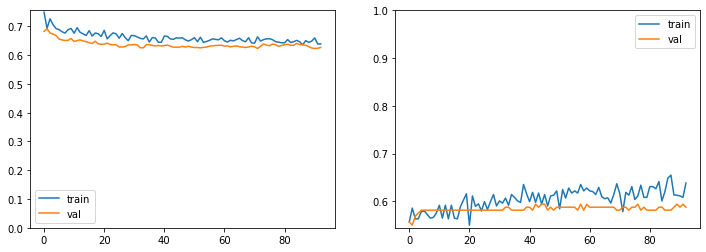

In [44]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### ~~19. Frames Too Heavy~~

#### 20. Frame Covering Eyes  

334 of 334
211 of 211
(435, 160, 160, 3) float32
(435,) int32
(110, 160, 160, 3) float32
(110,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 129s 1s/step - loss: 101.1140 - val_loss: 98.6330
Epoch 2/100
100/100 [==============================] - 121s 1s/step - loss: 99.9495 - val_loss: 96.5926
Epoch 3/100
100/100 [==============================] - 121s 1s/step - loss: 99.3954 - val_loss: 94.9119
Epoch 4/100
100/100 [==============================] - 120s 1s/step - loss: 98.0152 - val_loss: 94.7751
Epoch 5/100
100/100 [==============================] - 120s 1s/step - loss: 97.1759 - val_loss: 94.2914
Epoch 6/100
100/100 [==============================] - 121s 1s/step - loss: 94.1578 - val_loss: 92.7211
Epoch 7/100
100/100 [==============================] - 120s 1s/step - loss: 87.4704 - val_loss: 89.8398
Epoch 8/100
100/100 [==============================] - 120s 1s/step - loss: 83.7754 - val_loss: 86.7665
Epoch 9/100
100/100 [==============================] - 120s 1s/step - loss: 81.4437 - val_loss: 90.0904
Epoch 10/100
100/100 [==============================] - 122s 1s

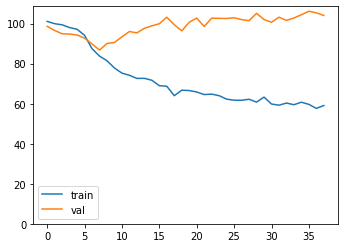

In [45]:
REQ_NAME = 'frame_covering_eyes'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
16/16 [==============================] - 6s 382ms/step - loss: 0.7801 - accuracy: 0.5020 - precision: 0.5104 - recall: 0.5215 - f1: 0.5074 - specificity: 0.4878 - negative_predictive_value: 0.4985 - matthews_correlation_coefficient: 0.0091 - equal_error_rate: 0.4997 - val_loss: 0.7096 - val_accuracy: 0.4922 - val_precision: 0.4375 - val_recall: 0.0842 - val_f1: 0.1396 - val_specificity: 0.9171 - val_negative_predictive_value: 0.4854 - val_matthews_correlation_coefficient: -0.0173 - val_equal_error_rate: 0.5145

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.01730, saving model to ../../models/siamese_networks/frame_covering_eyes_2020_06_13-14_21_57.h5
Epoch 2/100
16/16 [==============================] - 3s 174ms/step - loss: 0.7764 - accuracy: 0.5398 - precision: 0.5438 - recall: 0.4860 - f1: 0.5047 - specificity: 0.5958 - negative_predictive_value: 0.5397 - matthews_correlation_coefficient: 0.0826 - equal_error_rate: 0.4748 - val_loss: 0.6997 - 


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.13045
Epoch 14/100
16/16 [==============================] - 6s 381ms/step - loss: 0.7347 - accuracy: 0.5279 - precision: 0.5319 - recall: 0.5000 - f1: 0.5053 - specificity: 0.5497 - negative_predictive_value: 0.5184 - matthews_correlation_coefficient: 0.0500 - equal_error_rate: 0.4866 - val_loss: 0.6675 - val_accuracy: 0.5234 - val_precision: 0.6024 - val_recall: 0.2303 - val_f1: 0.3283 - val_specificity: 0.8425 - val_negative_predictive_value: 0.5069 - val_matthews_correlation_coefficient: 0.0891 - val_equal_error_rate: 0.3359

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.13045
Epoch 15/100
16/16 [==============================] - 6s 380ms/step - loss: 0.7231 - accuracy: 0.5398 - precision: 0.5167 - recall: 0.5404 - f1: 0.5148 - specificity: 0.5359 - negative_predictive_value: 0.5563 - matthews_correlation_coefficient: 0.0746 - equal_error_rate: 0.4510 - val_loss: 0.6657 - val_accurac

16/16 [==============================] - 6s 380ms/step - loss: 0.6969 - accuracy: 0.6135 - precision: 0.6134 - recall: 0.5436 - f1: 0.5715 - specificity: 0.6755 - negative_predictive_value: 0.6033 - matthews_correlation_coefficient: 0.2179 - equal_error_rate: 0.4066 - val_loss: 0.6635 - val_accuracy: 0.5625 - val_precision: 0.6667 - val_recall: 0.3061 - val_f1: 0.4144 - val_specificity: 0.8425 - val_negative_predictive_value: 0.5321 - val_matthews_correlation_coefficient: 0.1717 - val_equal_error_rate: 0.3823

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.17168
Epoch 28/100
16/16 [==============================] - 6s 385ms/step - loss: 0.6978 - accuracy: 0.5757 - precision: 0.5660 - recall: 0.5241 - f1: 0.5381 - specificity: 0.6181 - negative_predictive_value: 0.5757 - matthews_correlation_coefficient: 0.1419 - equal_error_rate: 0.4410 - val_loss: 0.6646 - val_accuracy: 0.5703 - val_precision: 0.6786 - val_recall: 0.3200 - val_f1: 0.4311 - val_specificity: 0.

16/16 [==============================] - 6s 384ms/step - loss: 0.6863 - accuracy: 0.5797 - precision: 0.5723 - recall: 0.5401 - f1: 0.5481 - specificity: 0.6233 - negative_predictive_value: 0.5834 - matthews_correlation_coefficient: 0.1595 - equal_error_rate: 0.4275 - val_loss: 0.6681 - val_accuracy: 0.5859 - val_precision: 0.6875 - val_recall: 0.3624 - val_f1: 0.4706 - val_specificity: 0.8300 - val_negative_predictive_value: 0.5494 - val_matthews_correlation_coefficient: 0.2135 - val_equal_error_rate: 0.3990

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.22831
Epoch 41/100
16/16 [==============================] - 6s 380ms/step - loss: 0.6732 - accuracy: 0.5837 - precision: 0.5878 - recall: 0.5597 - f1: 0.5667 - specificity: 0.6095 - negative_predictive_value: 0.5831 - matthews_correlation_coefficient: 0.1701 - equal_error_rate: 0.4249 - val_loss: 0.6693 - val_accuracy: 0.5859 - val_precision: 0.6875 - val_recall: 0.3624 - val_f1: 0.4706 - val_specificity: 0.


Epoch 00053: val_matthews_correlation_coefficient did not improve from 0.22831
Epoch 54/100
16/16 [==============================] - 6s 381ms/step - loss: 0.6897 - accuracy: 0.5657 - precision: 0.5647 - recall: 0.5362 - f1: 0.5413 - specificity: 0.6020 - negative_predictive_value: 0.5691 - matthews_correlation_coefficient: 0.1358 - equal_error_rate: 0.4407 - val_loss: 0.6620 - val_accuracy: 0.5859 - val_precision: 0.6875 - val_recall: 0.3624 - val_f1: 0.4706 - val_specificity: 0.8300 - val_negative_predictive_value: 0.5494 - val_matthews_correlation_coefficient: 0.2135 - val_equal_error_rate: 0.3901

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.22831
Epoch 55/100
16/16 [==============================] - 6s 379ms/step - loss: 0.6714 - accuracy: 0.5936 - precision: 0.6202 - recall: 0.5509 - f1: 0.5776 - specificity: 0.6382 - negative_predictive_value: 0.5705 - matthews_correlation_coefficient: 0.1898 - equal_error_rate: 0.3926 - val_loss: 0.6624 - val_accurac

16/16 [==============================] - 6s 383ms/step - loss: 0.6763 - accuracy: 0.5777 - precision: 0.5849 - recall: 0.5537 - f1: 0.5604 - specificity: 0.5946 - negative_predictive_value: 0.5704 - matthews_correlation_coefficient: 0.1516 - equal_error_rate: 0.4163 - val_loss: 0.6667 - val_accuracy: 0.5859 - val_precision: 0.6750 - val_recall: 0.3756 - val_f1: 0.4802 - val_specificity: 0.8108 - val_negative_predictive_value: 0.5484 - val_matthews_correlation_coefficient: 0.2040 - val_equal_error_rate: 0.4086

Epoch 00067: val_matthews_correlation_coefficient did not improve from 0.22831
Epoch 68/100
16/16 [==============================] - 6s 379ms/step - loss: 0.6734 - accuracy: 0.5817 - precision: 0.5898 - recall: 0.5544 - f1: 0.5633 - specificity: 0.6196 - negative_predictive_value: 0.5797 - matthews_correlation_coefficient: 0.1716 - equal_error_rate: 0.4091 - val_loss: 0.6623 - val_accuracy: 0.5859 - val_precision: 0.6750 - val_recall: 0.3756 - val_f1: 0.4802 - val_specificity: 0.


Epoch 00080: val_matthews_correlation_coefficient did not improve from 0.22831
Epoch 81/100
16/16 [==============================] - 6s 383ms/step - loss: 0.6790 - accuracy: 0.5916 - precision: 0.6121 - recall: 0.5258 - f1: 0.5549 - specificity: 0.6743 - negative_predictive_value: 0.5864 - matthews_correlation_coefficient: 0.1992 - equal_error_rate: 0.3984 - val_loss: 0.6595 - val_accuracy: 0.5938 - val_precision: 0.6944 - val_recall: 0.3756 - val_f1: 0.4845 - val_specificity: 0.8300 - val_negative_predictive_value: 0.5543 - val_matthews_correlation_coefficient: 0.2262 - val_equal_error_rate: 0.4160

Epoch 00081: val_matthews_correlation_coefficient did not improve from 0.22831
Epoch 82/100
16/16 [==============================] - 6s 380ms/step - loss: 0.6746 - accuracy: 0.5757 - precision: 0.5922 - recall: 0.5057 - f1: 0.5386 - specificity: 0.6471 - negative_predictive_value: 0.5647 - matthews_correlation_coefficient: 0.1547 - equal_error_rate: 0.4275 - val_loss: 0.6634 - val_accurac

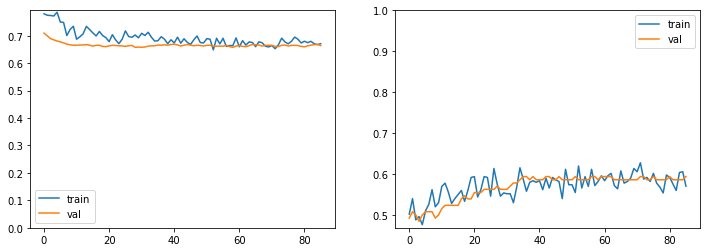

In [46]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 21. Hat/cap 

900 of 900
846 of 846
(1396, 160, 160, 3) float32
(1396,) int32
(350, 160, 160, 3) float32
(350,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 139s 1s/step - loss: 100.5317 - val_loss: 96.8414
Epoch 2/100
100/100 [==============================] - 125s 1s/step - loss: 99.1394 - val_loss: 87.2887
Epoch 3/100
100/100 [==============================] - 120s 1s/step - loss: 97.6820 - val_loss: 86.6457
Epoch 4/100
100/100 [==============================] - 118s 1s/step - loss: 94.3395 - val_loss: 81.0364
Epoch 5/100
100/100 [==============================] - 119s 1s/step - loss: 92.0027 - val_loss: 86.4147
Epoch 6/100
100/100 [==============================] - 126s 1s/step - loss: 87.9671 - val_loss: 90.9339
Epoch 7/100
100/100 [==============================] - 120s 1s/step - loss: 84.4007 - val_loss: 86.6748
Epoch 8/100
100/100 [==============================] - 118s 1s/step - loss: 82.5624 - val_loss: 88.1825
Epoch 9/100
100/100 [==============================] - 118s 1s/step - loss: 78.0994 - val_loss: 95.0025
Epoch 10/100
100/100 [==============================] - 126s 1s

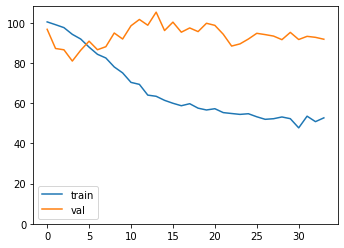

In [49]:
REQ_NAME = 'hat_cap'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
45/45 [==============================] - 20s 442ms/step - loss: 0.7642 - accuracy: 0.4931 - precision: 0.4928 - recall: 0.5018 - f1: 0.4888 - specificity: 0.4791 - negative_predictive_value: 0.4887 - matthews_correlation_coefficient: -0.0188 - equal_error_rate: 0.5158 - val_loss: 0.6533 - val_accuracy: 0.6108 - val_precision: 0.7412 - val_recall: 0.3294 - val_f1: 0.4425 - val_specificity: 0.8883 - val_negative_predictive_value: 0.5730 - val_matthews_correlation_coefficient: 0.2586 - val_equal_error_rate: 0.3353

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25864, saving model to ../../models/siamese_networks/hat_cap_2020_06_13-16_35_33.h5
Epoch 2/100
45/45 [==============================] - 16s 363ms/step - loss: 0.7407 - accuracy: 0.5083 - precision: 0.5116 - recall: 0.4734 - f1: 0.4815 - specificity: 0.5538 - negative_predictive_value: 0.5150 - matthews_correlation_coefficient: 0.0269 - equal_error_rate: 0.4867 - val_loss: 0.6429 - val_accurac


Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.36913
Epoch 14/100
45/45 [==============================] - 20s 437ms/step - loss: 0.6973 - accuracy: 0.5382 - precision: 0.5374 - recall: 0.5230 - f1: 0.5244 - specificity: 0.5535 - negative_predictive_value: 0.5400 - matthews_correlation_coefficient: 0.0769 - equal_error_rate: 0.4538 - val_loss: 0.6305 - val_accuracy: 0.6335 - val_precision: 0.8386 - val_recall: 0.3000 - val_f1: 0.4336 - val_specificity: 0.9714 - val_negative_predictive_value: 0.5835 - val_matthews_correlation_coefficient: 0.3420 - val_equal_error_rate: 0.3417

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.36913
Epoch 15/100
45/45 [==============================] - 20s 436ms/step - loss: 0.6825 - accuracy: 0.5472 - precision: 0.5506 - recall: 0.5272 - f1: 0.5311 - specificity: 0.5701 - negative_predictive_value: 0.5477 - matthews_correlation_coefficient: 0.0978 - equal_error_rate: 0.4447 - val_loss: 0.6322 - val_accur

45/45 [==============================] - 20s 435ms/step - loss: 0.6764 - accuracy: 0.5757 - precision: 0.5871 - recall: 0.5244 - f1: 0.5475 - specificity: 0.6282 - negative_predictive_value: 0.5689 - matthews_correlation_coefficient: 0.1543 - equal_error_rate: 0.4411 - val_loss: 0.6364 - val_accuracy: 0.6250 - val_precision: 0.8091 - val_recall: 0.2924 - val_f1: 0.4208 - val_specificity: 0.9608 - val_negative_predictive_value: 0.5786 - val_matthews_correlation_coefficient: 0.3168 - val_equal_error_rate: 0.3160

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.36913
Epoch 28/100
45/45 [==============================] - 20s 436ms/step - loss: 0.6842 - accuracy: 0.5528 - precision: 0.5607 - recall: 0.4953 - f1: 0.5186 - specificity: 0.6123 - negative_predictive_value: 0.5485 - matthews_correlation_coefficient: 0.1083 - equal_error_rate: 0.4476 - val_loss: 0.6368 - val_accuracy: 0.6278 - val_precision: 0.8152 - val_recall: 0.3000 - val_f1: 0.4291 - val_specificity: 


Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.36913
Epoch 41/100
45/45 [==============================] - 20s 435ms/step - loss: 0.6760 - accuracy: 0.5632 - precision: 0.5631 - recall: 0.5435 - f1: 0.5416 - specificity: 0.5936 - negative_predictive_value: 0.5746 - matthews_correlation_coefficient: 0.1373 - equal_error_rate: 0.4235 - val_loss: 0.6284 - val_accuracy: 0.6278 - val_precision: 0.8152 - val_recall: 0.3000 - val_f1: 0.4291 - val_specificity: 0.9608 - val_negative_predictive_value: 0.5810 - val_matthews_correlation_coefficient: 0.3249 - val_equal_error_rate: 0.3357

Epoch 00041: val_matthews_correlation_coefficient did not improve from 0.36913
Epoch 42/100
45/45 [==============================] - 20s 436ms/step - loss: 0.6812 - accuracy: 0.5465 - precision: 0.5590 - recall: 0.4663 - f1: 0.5001 - specificity: 0.6286 - negative_predictive_value: 0.5403 - matthews_correlation_coefficient: 0.0971 - equal_error_rate: 0.4599 - val_loss: 0.6293 - val_accur

45/45 [==============================] - 20s 437ms/step - loss: 0.6709 - accuracy: 0.5903 - precision: 0.6015 - recall: 0.5430 - f1: 0.5610 - specificity: 0.6455 - negative_predictive_value: 0.5877 - matthews_correlation_coefficient: 0.1888 - equal_error_rate: 0.4092 - val_loss: 0.6218 - val_accuracy: 0.6250 - val_precision: 0.7970 - val_recall: 0.3000 - val_f1: 0.4273 - val_specificity: 0.9551 - val_negative_predictive_value: 0.5795 - val_matthews_correlation_coefficient: 0.3140 - val_equal_error_rate: 0.3503

Epoch 00054: val_matthews_correlation_coefficient did not improve from 0.36913
Epoch 55/100
45/45 [==============================] - 20s 437ms/step - loss: 0.6682 - accuracy: 0.5896 - precision: 0.6083 - recall: 0.5025 - f1: 0.5403 - specificity: 0.6793 - negative_predictive_value: 0.5788 - matthews_correlation_coefficient: 0.1842 - equal_error_rate: 0.4256 - val_loss: 0.6268 - val_accuracy: 0.6250 - val_precision: 0.7970 - val_recall: 0.3000 - val_f1: 0.4273 - val_specificity: 

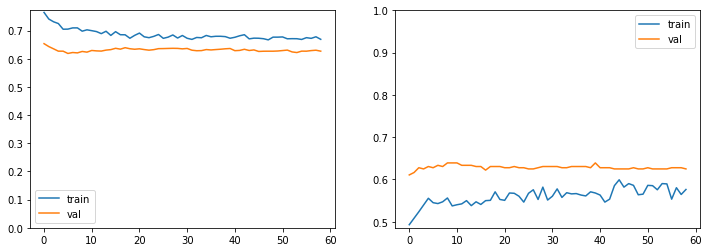

In [50]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### *22. Veil Over Face*

354 of 354
354 of 354
(566, 160, 160, 3) float32
(566,) int32
(142, 160, 160, 3) float32
(142,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 144s 1s/step - loss: 92.4138 - val_loss: 63.5170
Epoch 2/100
100/100 [==============================] - 135s 1s/step - loss: 77.6299 - val_loss: 53.7463
Epoch 3/100
100/100 [==============================] - 131s 1s/step - loss: 69.3410 - val_loss: 52.2096
Epoch 4/100
100/100 [==============================] - 135s 1s/step - loss: 64.3497 - val_loss: 54.7142
Epoch 5/100
100/100 [==============================] - 131s 1s/step - loss: 61.7075 - val_loss: 53.8340
Epoch 6/100
100/100 [==============================] - 135s 1s/step - loss: 58.0639 - val_loss: 52.5782
Epoch 7/100
100/100 [==============================] - 130s 1s/step - loss: 55.0462 - val_loss: 52.8140
Epoch 8/100
100/100 [==============================] - 135s 1s/step - loss: 54.1296 - val_loss: 53.5710
Epoch 9/100
100/100 [==============================] - 130s 1s/step - loss: 51.7183 - val_loss: 55.1299
Epoch 10/100
100/100 [==============================] - 135s 1s/

100/100 [==============================] - 130s 1s/step - loss: 22.0780 - val_loss: 48.3778
Epoch 80/100
100/100 [==============================] - 135s 1s/step - loss: 22.7351 - val_loss: 48.4244
Epoch 81/100
100/100 [==============================] - 130s 1s/step - loss: 20.9375 - val_loss: 47.8322
Epoch 82/100
100/100 [==============================] - 135s 1s/step - loss: 22.5980 - val_loss: 49.0710
Epoch 83/100
100/100 [==============================] - 130s 1s/step - loss: 22.9766 - val_loss: 49.9987
Epoch 84/100
100/100 [==============================] - 135s 1s/step - loss: 23.4328 - val_loss: 49.5709
Epoch 85/100
100/100 [==============================] - 130s 1s/step - loss: 21.7370 - val_loss: 49.9105
Epoch 86/100
100/100 [==============================] - 135s 1s/step - loss: 23.3513 - val_loss: 49.8416
Epoch 87/100
100/100 [==============================] - 130s 1s/step - loss: 23.4134 - val_loss: 49.1332
Epoch 88/100
100/100 [==============================] - 135s 1s/step

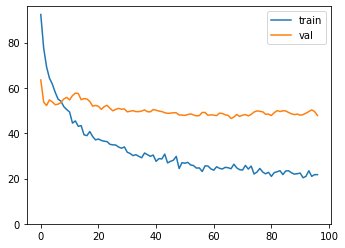

In [51]:
REQ_NAME = 'veil_over_face'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
17/17 [==============================] - 8s 444ms/step - loss: 1.0517 - accuracy: 0.4007 - precision: 0.4407 - recall: 0.6996 - f1: 0.5310 - specificity: 0.1036 - negative_predictive_value: 0.2604 - matthews_correlation_coefficient: -0.2399 - equal_error_rate: 0.6716 - val_loss: 0.7703 - val_accuracy: 0.4531 - val_precision: 0.4723 - val_recall: 0.6167 - val_f1: 0.5326 - val_specificity: 0.2865 - val_negative_predictive_value: 0.4129 - val_matthews_correlation_coefficient: -0.1053 - val_equal_error_rate: 0.5000

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.10528, saving model to ../../models/siamese_networks/veil_over_face_2020_06_13-20_33_09.h5
Epoch 2/100
17/17 [==============================] - 4s 217ms/step - loss: 0.8622 - accuracy: 0.4288 - precision: 0.4496 - recall: 0.5622 - f1: 0.4915 - specificity: 0.2818 - negative_predictive_value: 0.3934 - matthews_correlation_coefficient: -0.1562 - equal_error_rate: 0.5541 - val_loss: 0.7702 - val


Epoch 00013: val_matthews_correlation_coefficient improved from -0.01928 to -0.01482, saving model to ../../models/siamese_networks/veil_over_face_2020_06_13-20_33_09.h5
Epoch 14/100
17/17 [==============================] - 8s 442ms/step - loss: 0.5281 - accuracy: 0.7322 - precision: 0.7514 - recall: 0.7001 - f1: 0.7134 - specificity: 0.7723 - negative_predictive_value: 0.7289 - matthews_correlation_coefficient: 0.4759 - equal_error_rate: 0.2760 - val_loss: 1.0974 - val_accuracy: 0.4922 - val_precision: 0.5006 - val_recall: 0.9090 - val_f1: 0.6448 - val_specificity: 0.0646 - val_negative_predictive_value: 0.3500 - val_matthews_correlation_coefficient: -0.0597 - val_equal_error_rate: 0.3281

Epoch 00014: val_matthews_correlation_coefficient did not improve from -0.01482
Epoch 15/100
17/17 [==============================] - 8s 446ms/step - loss: 0.5753 - accuracy: 0.7210 - precision: 0.7273 - recall: 0.6846 - f1: 0.6989 - specificity: 0.7434 - negative_predictive_value: 0.6981 - matthew

17/17 [==============================] - 8s 476ms/step - loss: 0.5114 - accuracy: 0.7622 - precision: 0.7978 - recall: 0.7051 - f1: 0.7386 - specificity: 0.8196 - negative_predictive_value: 0.7389 - matthews_correlation_coefficient: 0.5300 - equal_error_rate: 0.2444 - val_loss: 1.1451 - val_accuracy: 0.5000 - val_precision: 0.5043 - val_recall: 0.9550 - val_f1: 0.6595 - val_specificity: 0.0323 - val_negative_predictive_value: 0.3333 - val_matthews_correlation_coefficient: -0.0218 - val_equal_error_rate: 0.2812

Epoch 00027: val_matthews_correlation_coefficient did not improve from -0.01482
Epoch 28/100
17/17 [==============================] - 8s 442ms/step - loss: 0.5226 - accuracy: 0.7416 - precision: 0.7531 - recall: 0.6967 - f1: 0.7154 - specificity: 0.7652 - negative_predictive_value: 0.7203 - matthews_correlation_coefficient: 0.4672 - equal_error_rate: 0.2501 - val_loss: 1.1050 - val_accuracy: 0.5000 - val_precision: 0.5043 - val_recall: 0.9550 - val_f1: 0.6595 - val_specificity: 


Epoch 00040: val_matthews_correlation_coefficient did not improve from -0.01482
Epoch 41/100
17/17 [==============================] - 7s 441ms/step - loss: 0.4819 - accuracy: 0.7547 - precision: 0.8163 - recall: 0.6671 - f1: 0.7281 - specificity: 0.8365 - negative_predictive_value: 0.7046 - matthews_correlation_coefficient: 0.5115 - equal_error_rate: 0.2426 - val_loss: 1.0400 - val_accuracy: 0.5000 - val_precision: 0.5043 - val_recall: 0.9550 - val_f1: 0.6595 - val_specificity: 0.0323 - val_negative_predictive_value: 0.3333 - val_matthews_correlation_coefficient: -0.0218 - val_equal_error_rate: 0.2342

Epoch 00041: val_matthews_correlation_coefficient did not improve from -0.01482
Epoch 42/100
17/17 [==============================] - 8s 444ms/step - loss: 0.4990 - accuracy: 0.7753 - precision: 0.8072 - recall: 0.7229 - f1: 0.7505 - specificity: 0.8309 - negative_predictive_value: 0.7528 - matthews_correlation_coefficient: 0.5564 - equal_error_rate: 0.2211 - val_loss: 1.0293 - val_accu

17/17 [==============================] - 7s 441ms/step - loss: 0.4760 - accuracy: 0.7659 - precision: 0.8125 - recall: 0.6935 - f1: 0.7355 - specificity: 0.8338 - negative_predictive_value: 0.7326 - matthews_correlation_coefficient: 0.5349 - equal_error_rate: 0.2111 - val_loss: 0.9509 - val_accuracy: 0.5000 - val_precision: 0.5043 - val_recall: 0.9550 - val_f1: 0.6595 - val_specificity: 0.0323 - val_negative_predictive_value: 0.3333 - val_matthews_correlation_coefficient: -0.0218 - val_equal_error_rate: 0.2342

Epoch 00054: val_matthews_correlation_coefficient did not improve from -0.01482
Epoch 55/100
17/17 [==============================] - 8s 453ms/step - loss: 0.4900 - accuracy: 0.7739 - precision: 0.8072 - recall: 0.6967 - f1: 0.7428 - specificity: 0.8392 - negative_predictive_value: 0.7374 - matthews_correlation_coefficient: 0.5398 - equal_error_rate: 0.2183 - val_loss: 0.9864 - val_accuracy: 0.4922 - val_precision: 0.5003 - val_recall: 0.9550 - val_f1: 0.6560 - val_specificity: 

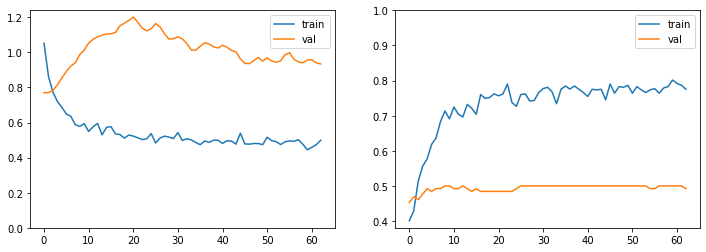

In [52]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### 23. Mouth Open 

452 of 452
420 of 420
(697, 160, 160, 3) float32
(697,) int32
(175, 160, 160, 3) float32
(175,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 143s 1s/step - loss: 98.2634 - val_loss: 91.3517
Epoch 2/100
100/100 [==============================] - 131s 1s/step - loss: 95.2340 - val_loss: 83.1551
Epoch 3/100
100/100 [==============================] - 131s 1s/step - loss: 90.1602 - val_loss: 83.6418
Epoch 4/100
100/100 [==============================] - 131s 1s/step - loss: 87.9508 - val_loss: 84.6558
Epoch 5/100
100/100 [==============================] - 131s 1s/step - loss: 85.7679 - val_loss: 86.0906
Epoch 6/100
100/100 [==============================] - 131s 1s/step - loss: 82.4420 - val_loss: 88.6299
Epoch 7/100
100/100 [==============================] - 131s 1s/step - loss: 82.1051 - val_loss: 88.2874
Epoch 8/100
100/100 [==============================] - 131s 1s/step - loss: 79.4407 - val_loss: 87.1899
Epoch 9/100
100/100 [==============================] - 130s 1s/step - loss: 79.7251 - val_loss: 87.7099
Epoch 10/100
100/100 [==============================] - 130s 1s/

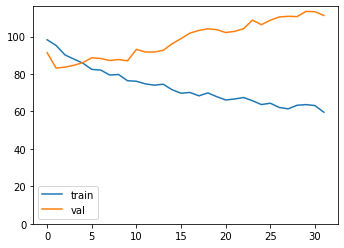

In [53]:
REQ_NAME = 'mouth_open'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
22/22 [==============================] - 10s 474ms/step - loss: 0.7402 - accuracy: 0.4943 - precision: 0.4919 - recall: 0.5935 - f1: 0.5311 - specificity: 0.3979 - negative_predictive_value: 0.4999 - matthews_correlation_coefficient: -0.0085 - equal_error_rate: 0.5017 - val_loss: 0.6981 - val_accuracy: 0.4688 - val_precision: 0.4733 - val_recall: 0.6110 - val_f1: 0.5295 - val_specificity: 0.3095 - val_negative_predictive_value: 0.4450 - val_matthews_correlation_coefficient: -0.0806 - val_equal_error_rate: 0.5257

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to -0.08059, saving model to ../../models/siamese_networks/mouth_open_2020_06_13-21_55_23.h5
Epoch 2/100
22/22 [==============================] - 6s 285ms/step - loss: 0.7261 - accuracy: 0.5029 - precision: 0.5001 - recall: 0.5647 - f1: 0.5247 - specificity: 0.4357 - negative_predictive_value: 0.5046 - matthews_correlation_coefficient: 0.0026 - equal_error_rate: 0.5136 - val_loss: 0.6714 - val_acc

22/22 [==============================] - 10s 471ms/step - loss: 0.6821 - accuracy: 0.5754 - precision: 0.5788 - recall: 0.6409 - f1: 0.6012 - specificity: 0.5127 - negative_predictive_value: 0.5742 - matthews_correlation_coefficient: 0.1532 - equal_error_rate: 0.3939 - val_loss: 0.6035 - val_accuracy: 0.6000 - val_precision: 0.5809 - val_recall: 0.6372 - val_f1: 0.6075 - val_specificity: 0.5459 - val_negative_predictive_value: 0.6067 - val_matthews_correlation_coefficient: 0.1853 - val_equal_error_rate: 0.3671

Epoch 00013: val_matthews_correlation_coefficient did not improve from 0.19738
Epoch 14/100
22/22 [==============================] - 10s 472ms/step - loss: 0.6892 - accuracy: 0.5507 - precision: 0.5548 - recall: 0.6106 - f1: 0.5710 - specificity: 0.5023 - negative_predictive_value: 0.5606 - matthews_correlation_coefficient: 0.1141 - equal_error_rate: 0.4313 - val_loss: 0.6007 - val_accuracy: 0.6062 - val_precision: 0.5856 - val_recall: 0.6489 - val_f1: 0.6155 - val_specificity: 

22/22 [==============================] - 10s 468ms/step - loss: 0.6965 - accuracy: 0.5188 - precision: 0.5117 - recall: 0.5315 - f1: 0.5172 - specificity: 0.4986 - negative_predictive_value: 0.5160 - matthews_correlation_coefficient: 0.0289 - equal_error_rate: 0.4663 - val_loss: 0.5869 - val_accuracy: 0.6313 - val_precision: 0.6099 - val_recall: 0.6467 - val_f1: 0.6269 - val_specificity: 0.5991 - val_negative_predictive_value: 0.6393 - val_matthews_correlation_coefficient: 0.2475 - val_equal_error_rate: 0.3545

Epoch 00026: val_matthews_correlation_coefficient improved from 0.23674 to 0.24751, saving model to ../../models/siamese_networks/mouth_open_2020_06_13-21_55_23.h5
Epoch 27/100
22/22 [==============================] - 10s 469ms/step - loss: 0.6876 - accuracy: 0.5435 - precision: 0.5469 - recall: 0.5960 - f1: 0.5638 - specificity: 0.4921 - negative_predictive_value: 0.5366 - matthews_correlation_coefficient: 0.0858 - equal_error_rate: 0.4631 - val_loss: 0.5867 - val_accuracy: 0.6


Epoch 00038: val_matthews_correlation_coefficient did not improve from 0.33262
Epoch 39/100
22/22 [==============================] - 10s 470ms/step - loss: 0.6692 - accuracy: 0.5754 - precision: 0.5751 - recall: 0.6130 - f1: 0.5859 - specificity: 0.5428 - negative_predictive_value: 0.5795 - matthews_correlation_coefficient: 0.1551 - equal_error_rate: 0.4113 - val_loss: 0.5788 - val_accuracy: 0.6625 - val_precision: 0.6500 - val_recall: 0.6467 - val_f1: 0.6471 - val_specificity: 0.6665 - val_negative_predictive_value: 0.6613 - val_matthews_correlation_coefficient: 0.3122 - val_equal_error_rate: 0.3243

Epoch 00039: val_matthews_correlation_coefficient did not improve from 0.33262
Epoch 40/100
22/22 [==============================] - 10s 473ms/step - loss: 0.6688 - accuracy: 0.6000 - precision: 0.5990 - recall: 0.6588 - f1: 0.6165 - specificity: 0.5572 - negative_predictive_value: 0.6196 - matthews_correlation_coefficient: 0.2171 - equal_error_rate: 0.3812 - val_loss: 0.5774 - val_accur


Epoch 00051: val_matthews_correlation_coefficient did not improve from 0.38260
Epoch 52/100
22/22 [==============================] - 10s 471ms/step - loss: 0.6784 - accuracy: 0.5565 - precision: 0.5572 - recall: 0.5654 - f1: 0.5514 - specificity: 0.5543 - negative_predictive_value: 0.5639 - matthews_correlation_coefficient: 0.1204 - equal_error_rate: 0.4279 - val_loss: 0.5691 - val_accuracy: 0.6938 - val_precision: 0.6889 - val_recall: 0.6806 - val_f1: 0.6818 - val_specificity: 0.7026 - val_negative_predictive_value: 0.6913 - val_matthews_correlation_coefficient: 0.3817 - val_equal_error_rate: 0.2942

Epoch 00052: val_matthews_correlation_coefficient did not improve from 0.38260
Epoch 53/100
22/22 [==============================] - 10s 469ms/step - loss: 0.6785 - accuracy: 0.5768 - precision: 0.5756 - recall: 0.5812 - f1: 0.5736 - specificity: 0.5639 - negative_predictive_value: 0.5692 - matthews_correlation_coefficient: 0.1449 - equal_error_rate: 0.4297 - val_loss: 0.5687 - val_accur

22/22 [==============================] - 10s 470ms/step - loss: 0.6703 - accuracy: 0.5768 - precision: 0.5851 - recall: 0.6002 - f1: 0.5867 - specificity: 0.5671 - negative_predictive_value: 0.5743 - matthews_correlation_coefficient: 0.1633 - equal_error_rate: 0.4189 - val_loss: 0.5638 - val_accuracy: 0.7000 - val_precision: 0.6958 - val_recall: 0.6800 - val_f1: 0.6835 - val_specificity: 0.7144 - val_negative_predictive_value: 0.7017 - val_matthews_correlation_coefficient: 0.3958 - val_equal_error_rate: 0.2941

Epoch 00065: val_matthews_correlation_coefficient did not improve from 0.40761
Epoch 66/100
22/22 [==============================] - 10s 475ms/step - loss: 0.6750 - accuracy: 0.5710 - precision: 0.5848 - recall: 0.5902 - f1: 0.5747 - specificity: 0.5603 - negative_predictive_value: 0.5686 - matthews_correlation_coefficient: 0.1519 - equal_error_rate: 0.4276 - val_loss: 0.5639 - val_accuracy: 0.7000 - val_precision: 0.6958 - val_recall: 0.6800 - val_f1: 0.6835 - val_specificity: 

22/22 [==============================] - 10s 472ms/step - loss: 0.6726 - accuracy: 0.5826 - precision: 0.5784 - recall: 0.5547 - f1: 0.5599 - specificity: 0.5998 - negative_predictive_value: 0.5764 - matthews_correlation_coefficient: 0.1546 - equal_error_rate: 0.4076 - val_loss: 0.5648 - val_accuracy: 0.6938 - val_precision: 0.7050 - val_recall: 0.6456 - val_f1: 0.6663 - val_specificity: 0.7404 - val_negative_predictive_value: 0.6862 - val_matthews_correlation_coefficient: 0.3885 - val_equal_error_rate: 0.2869

Epoch 00078: val_matthews_correlation_coefficient did not improve from 0.40869
Epoch 79/100
22/22 [==============================] - 10s 469ms/step - loss: 0.6726 - accuracy: 0.5913 - precision: 0.5875 - recall: 0.5926 - f1: 0.5826 - specificity: 0.5880 - negative_predictive_value: 0.5907 - matthews_correlation_coefficient: 0.1794 - equal_error_rate: 0.4036 - val_loss: 0.5653 - val_accuracy: 0.6938 - val_precision: 0.7050 - val_recall: 0.6456 - val_f1: 0.6663 - val_specificity: 

22/22 [==============================] - 10s 475ms/step - loss: 0.6546 - accuracy: 0.6304 - precision: 0.6342 - recall: 0.6383 - f1: 0.6277 - specificity: 0.6314 - negative_predictive_value: 0.6317 - matthews_correlation_coefficient: 0.2678 - equal_error_rate: 0.3600 - val_loss: 0.5546 - val_accuracy: 0.7063 - val_precision: 0.7110 - val_recall: 0.6695 - val_f1: 0.6857 - val_specificity: 0.7429 - val_negative_predictive_value: 0.6985 - val_matthews_correlation_coefficient: 0.4109 - val_equal_error_rate: 0.2941

Epoch 00091: val_matthews_correlation_coefficient did not improve from 0.41127
Epoch 92/100
22/22 [==============================] - 10s 475ms/step - loss: 0.6674 - accuracy: 0.5812 - precision: 0.5887 - recall: 0.5928 - f1: 0.5850 - specificity: 0.5728 - negative_predictive_value: 0.5726 - matthews_correlation_coefficient: 0.1634 - equal_error_rate: 0.4100 - val_loss: 0.5550 - val_accuracy: 0.7063 - val_precision: 0.7110 - val_recall: 0.6695 - val_f1: 0.6857 - val_specificity: 

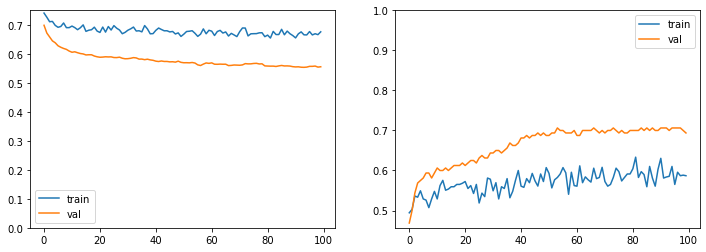

In [54]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

#### *24. Presence of Other Faces or Toys too Close to Face*

64 of 64
18 of 18
(65, 160, 160, 3) float32
(65,) int32
(17, 160, 160, 3) float32
(17,) int32


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
100/100 [==============================] - 74s 739ms/step - loss: 99.5102 - val_loss: 98.8131
Epoch 2/100
100/100 [==============================] - 64s 637ms/step - loss: 96.9934 - val_loss: 97.4392
Epoch 3/100
100/100 [==============================] - 63s 635ms/step - loss: 94.5410 - val_loss: 95.5504
Epoch 4/100
100/100 [==============================] - 63s 634ms/step - loss: 91.6819 - val_loss: 90.0420
Epoch 5/100
100/100 [==============================] - 63s 634ms/step - loss: 90.4083 - val_loss: 93.8697
Epoch 6/100
100/100 [==============================] - 64s 638ms/step - loss: 86.9963 - val_loss: 93.5676
Epoch 7/100
100/100 [==============================] - 63s 635ms/step - loss: 83.9718 - val_loss: 95.1065
Epoch 8/100
100/100 [==============================] - 64s 638ms/step - loss: 78.9148 - val_loss: 94.2989
Epoch 9/100
100/100 [==============================] - 64s 635ms/step - loss: 76.6919 - val_loss: 86.0589
Epoch 10/100
100/100 [========================

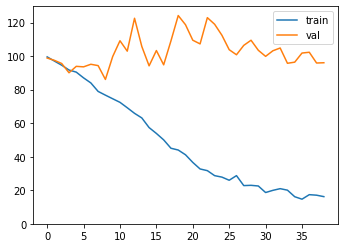

In [55]:
REQ_NAME = 'presence_of_other_faces_or_toys'

x_pos_train, x_pos_valid, x_neg_train, x_neg_valid = load_pos_and_neg_images(REQ_NAME)
x_train, y_train, x_valid, y_valid = setup_train_and_valid_sets(x_pos_train, x_pos_valid, x_neg_train, x_neg_valid)
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print(x_valid.shape, x_valid.dtype)
print(y_valid.shape, y_valid.dtype)

train_gen = ImageDataGenerator(
    rotation_range=10,
    brightness_range=(0.7, 1.3),
    zoom_range=0.1,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    rescale=1 / 255
)
valid_gen = ImageDataGenerator(rescale=1 / 255)

model_shared = run_siamese_training(
    file_encoder=FILE_BASE_MODEL, 
    train_data=(x_pos_train, x_neg_train), 
    valid_data=(x_pos_valid, x_neg_valid), 
    train_gen=train_gen, 
    valid_gen=valid_gen,
    name=REQ_NAME
)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
3/3 [==============================] - 6s 2s/step - loss: 0.8663 - accuracy: 0.4896 - precision: 0.4963 - recall: 0.8093 - f1: 0.6152 - specificity: 0.1469 - negative_predictive_value: 0.4556 - matthews_correlation_coefficient: -0.0486 - equal_error_rate: 0.4571 - val_loss: 0.8376 - val_accuracy: 0.4706 - val_precision: 0.4706 - val_recall: 1.0000 - val_f1: 0.6400 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: 0.0000e+00 - val_equal_error_rate: 0.4792

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.00000, saving model to ../../models/siamese_networks/presence_of_other_faces_or_toys_2020_06_13-22_58_01.h5
Epoch 2/100
3/3 [==============================] - 1s 206ms/step - loss: 0.9790 - accuracy: 0.4286 - precision: 0.4333 - recall: 0.8472 - f1: 0.5600 - specificity: 0.0476 - negative_predictive_value: 0.0833 - matthews_correlation_coefficient: -0.1588 - equal_error_rate: 0.5412 - va

3/3 [==============================] - 1s 349ms/step - loss: 0.7999 - accuracy: 0.5143 - precision: 0.4781 - recall: 0.5000 - f1: 0.4825 - specificity: 0.5179 - negative_predictive_value: 0.5407 - matthews_correlation_coefficient: 0.0183 - equal_error_rate: 0.6033 - val_loss: 0.7520 - val_accuracy: 0.3529 - val_precision: 0.4000 - val_recall: 0.7500 - val_f1: 0.5217 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.3873 - val_equal_error_rate: 0.7083

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.00000
Epoch 15/100
3/3 [==============================] - 1s 367ms/step - loss: 0.7364 - accuracy: 0.5286 - precision: 0.4569 - recall: 0.5097 - f1: 0.4774 - specificity: 0.5319 - negative_predictive_value: 0.5850 - matthews_correlation_coefficient: 0.0417 - equal_error_rate: 0.4375 - val_loss: 0.7504 - val_accuracy: 0.3529 - val_precision: 0.4000 - val_recall: 0.7500 - val_f1: 0.5217 - val_specificit

3/3 [==============================] - 1s 371ms/step - loss: 0.6877 - accuracy: 0.6571 - precision: 0.7685 - recall: 0.5764 - f1: 0.6385 - specificity: 0.7806 - negative_predictive_value: 0.6976 - matthews_correlation_coefficient: 0.4057 - equal_error_rate: 0.3861 - val_loss: 0.7520 - val_accuracy: 0.3529 - val_precision: 0.4000 - val_recall: 0.7500 - val_f1: 0.5217 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: -0.3873 - val_equal_error_rate: 0.4167

Epoch 00027: val_matthews_correlation_coefficient did not improve from 0.00000
Epoch 28/100
3/3 [==============================] - 1s 379ms/step - loss: 0.7003 - accuracy: 0.5571 - precision: 0.4906 - recall: 0.5630 - f1: 0.5124 - specificity: 0.5336 - negative_predictive_value: 0.6126 - matthews_correlation_coefficient: 0.0998 - equal_error_rate: 0.4053 - val_loss: 0.7531 - val_accuracy: 0.3529 - val_precision: 0.4000 - val_recall: 0.7500 - val_f1: 0.5217 - val_specificit

3/3 [==============================] - 1s 360ms/step - loss: 0.7596 - accuracy: 0.4429 - precision: 0.4596 - recall: 0.3889 - f1: 0.4157 - specificity: 0.6015 - negative_predictive_value: 0.5301 - matthews_correlation_coefficient: -0.0099 - equal_error_rate: 0.4778 - val_loss: 0.7560 - val_accuracy: 0.4706 - val_precision: 0.4545 - val_recall: 0.6250 - val_f1: 0.5263 - val_specificity: 0.3333 - val_negative_predictive_value: 0.5000 - val_matthews_correlation_coefficient: -0.0435 - val_equal_error_rate: 0.4722

Epoch 00040: val_matthews_correlation_coefficient did not improve from 0.00000
Epoch 41/100
3/3 [==============================] - 2s 505ms/step - loss: 0.6825 - accuracy: 0.5938 - precision: 0.6333 - recall: 0.5245 - f1: 0.5654 - specificity: 0.6584 - negative_predictive_value: 0.5656 - matthews_correlation_coefficient: 0.1905 - equal_error_rate: 0.4058 - val_loss: 0.7572 - val_accuracy: 0.4706 - val_precision: 0.4545 - val_recall: 0.6250 - val_f1: 0.5263 - val_specificity: 0.33

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


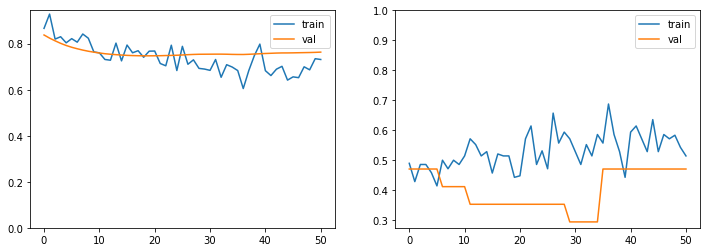

In [56]:
file_model = run_classification_training(
    model_shared=model_shared,
    train_data=(x_train, y_train),
    valid_data=(x_valid, y_valid),
    train_gen=train_gen,
    valid_gen=valid_gen,
    name=REQ_NAME
)

list_model_files.append(file_model)

In [57]:
print(len(list_model_files))
print(np.array(list_model_files))

21
['../../models/siamese_networks/blurred_2020_06_13-00_54_46.h5'
 '../../models/siamese_networks/looking_away_2020_06_13-01_29_34.h5'
 '../../models/siamese_networks/unnatural_skin_tone_2020_06_13-02_13_13.h5'
 '../../models/siamese_networks/too_dark_light_2020_06_13-02_38_15.h5'
 '../../models/siamese_networks/washed_out_2020_06_13-03_07_04.h5'
 '../../models/siamese_networks/pixelation_2020_06_13-03_47_04.h5'
 '../../models/siamese_networks/hair_across_eyes_2020_06_13-04_35_06.h5'
 '../../models/siamese_networks/eyes_closed_2020_06_13-05_09_51.h5'
 '../../models/siamese_networks/varied_background_2020_06_13-05_56_29.h5'
 '../../models/siamese_networks/roll_pitch_yaw_2020_06_13-07_19_15.h5'
 '../../models/siamese_networks/flash_reflection_on_skin_2020_06_13-08_10_19.h5'
 '../../models/siamese_networks/red_eyes_2020_06_13-09_42_38.h5'
 '../../models/siamese_networks/shadows_behind_head_2020_06_13-10_19_02.h5'
 '../../models/siamese_networks/shadows_across_face_2020_06_13-10_58_25.h5'

# Models Merge

In [58]:
def load_shared_model(file_autoencoder):
    autoencoder = load_model(file_autoencoder)
    encoder_output = autoencoder.get_layer(name='encoded').output
    embeddings = GlobalAvgPool2D(name='embeddings')(encoder_output)
    shared_model = Model(inputs=autoencoder.inputs, outputs=embeddings)
    return shared_model


def add_requirement_branch_to_base_model(base_model, req_model):
    n_layers = len(base_model.layers)
    req_layers = [layer for layer in req_model.layers[n_layers:]]

    outputs = base_model.output
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)
    return outputs

In [59]:
shared_model = load_shared_model(FILE_BASE_MODEL)
shared_model.summary()

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "model_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 80, 80, 64)        256

In [60]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc,
    'equal_error_rate': eer
}

list_models = [load_model(file, custom_objects=custom_objects) for file in list_model_files]
list_outputs = [add_requirement_branch_to_base_model(shared_model, req_model) for req_model in list_models]

In [61]:
FILE_MERGED_MODEL = FOLDER_MODELS + '/' + timestamp_model_name(prefix='merged_model_')
print(FILE_MERGED_MODEL)

merged_model = Model(inputs=shared_model.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(FILE_MERGED_MODEL)

../../models/siamese_networks/merged_model_2020_06_13-23_23_26.h5
Model: "model_86"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
_________________________

In [62]:
import cv2
from glob import glob

list_files = ['../../data/cropped_faces/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../../data/cropped_faces/images/AR_FDB_m-013-17.png
1 of 1


[array([[0.6860817]], dtype=float32),
 array([[0.471167]], dtype=float32),
 array([[0.12628101]], dtype=float32),
 array([[0.5145042]], dtype=float32),
 array([[0.537973]], dtype=float32),
 array([[0.51969695]], dtype=float32),
 array([[0.49658877]], dtype=float32),
 array([[0.66222686]], dtype=float32),
 array([[0.2807763]], dtype=float32),
 array([[0.2872316]], dtype=float32),
 array([[0.35849157]], dtype=float32),
 array([[0.23540272]], dtype=float32),
 array([[0.5119072]], dtype=float32),
 array([[0.43540823]], dtype=float32),
 array([[0.42510813]], dtype=float32),
 array([[0.37746102]], dtype=float32),
 array([[0.46417737]], dtype=float32),
 array([[0.5392513]], dtype=float32),
 array([[0.9042031]], dtype=float32),
 array([[0.39162204]], dtype=float32),
 array([[0.6339827]], dtype=float32)]